# Age Estimation using the YOLO algorithm

Authors: Isak Killingrød, Jon A B Larssen, Jon I J Skånøy

About

## Setup

#### **Conda**
```bash
	conda create -n yoloenv python=3.10 ipykernel -y
	conda activate yoloenv
```

#### **virtualenv**
```bash
	python -m venv yoloenv
	source yoloenv/bin/activate  # or .\yoloenv\Scripts\activate on Windows
	pip install --upgrade pip
	pip install ipykernel
```

#### **Ubuntu**
`python -m ipykernel install --user --name yoloenv --display-name "Python (yoloenv)"`

(Maybe wait a bit. The kernel command is sometimes slow on UiA server)

Then launch Jupyter and switch to the environment's kernel if needed.

#### Note

It has been a bit struggle with cross-platform package conflicts and it still output some warnings, but they should disappear on notebook restart


---------


### Installations

In [1]:
import os, sys, json, time, re, glob, random, warnings, tarfile, shutil
from pathlib import Path
from datetime import datetime
import platform, subprocess

In [ ]:
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ipywidgets", "requests", "tqdm", "optuna", "gdown"])

0

In [3]:
if platform.system() == "Windows":
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "torch==2.2.2+cu118", "torchvision==0.17.2+cu118", "--index-url", "https://download.pytorch.org/whl/cu118"])
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "pywin32"])
    print("Running on Windows")
    STORAGE = 'YOLO' #'YOLO_NB_LOCAL'
    MODEL_SIZES = ['n', 's', 'm', 'l','x']
    MODEL_VERSIONS = [8,9,10,11,12]
    IMAGE_SIZE = 416
elif platform.system() == "Linux":
    print("Running on Linux")
    STORAGE = 'YOLO' #'YOLO_NB_SERVER'
    MODEL_SIZES = ['x', 'l', 'm', 's', 'n']
    MODEL_VERSIONS = [12,11,10,9,8]
    IMAGE_SIZE = 416
else:
    print(f"Running on {platform.system()}")
    STORAGE = 'YOLO' #'YOLO_NB_UNKNOWN'

Running on Windows


In [4]:
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ultralytics", "facenet-pytorch"])

0

### Imports

In [5]:
%matplotlib inline
from tqdm.notebook import tqdm

In [6]:
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import cv2
import yaml
import optuna
from optuna.trial import TrialState
from ultralytics import YOLO
import gdown

import torch, torchvision
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN

In [7]:
print(f"✅ Torch version: {torch.__version__}")
print(f"✅ TorchVision version: {torchvision.__version__}")
print(f"🧠 CUDA available : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 CUDA device     : {torch.cuda.get_device_name(0)}")
    print(f"🔢 CUDA capability : {torch.cuda.get_device_capability(0)}")
    print(f"🧮 CUDA version    : {torch.version.cuda}")
else:
    print("⚠️ CUDA is NOT available in this environment.")


✅ Torch version: 2.2.2+cu118
✅ TorchVision version: 0.17.2+cu118
🧠 CUDA available : True
🚀 CUDA device     : NVIDIA GeForce RTX 3070
🔢 CUDA capability : (8, 6)
🧮 CUDA version    : 11.8


### Config

In [8]:
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
SPEEDRUN = False         # Only True if testing notebook functionality
USE_MAX_BATCH = False    # Only True if testing notebook functionality

In [ ]:
DOWNLOAD_OPTUNA_DB = True
RUN_OPTUNA = False
RUN_EXP_MODEL_SIZES = True
RUN_EXP_DATA_AUGMENTATION = True
RUN_EXP_MODEL_VERSIONS = True

In [ ]:
NUM_WORKERS = os.cpu_count() // 2 # For preprocessing, not tuning or training

In [12]:
USERNAME = 'adiencedb'
PASSWORD = 'adience'

In [13]:
DATA_DIR = 'data'
BASE_URL = 'http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/'
ARCHIVE_URL = BASE_URL + "faces.tar.gz"
ARCHIVE_PATH = os.path.join(DATA_DIR, "faces.tar.gz")

In [14]:
os.makedirs(DATA_DIR, exist_ok=True)

### Functions

#### Utils

In [15]:
def show_random_samples_with_bbox(image_dir, label_dir, creator, n=3):

    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in image_extensions]

    if len(image_files) < n:
        raise ValueError(f"Not enough images in {image_dir} to display {n} samples.")

    selected_images = random.sample(image_files, n)
    plt.figure(figsize=(5 * n, 5))

    for idx, img_file in enumerate(selected_images):
        img_path = os.path.join(image_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)

        if not os.path.exists(label_path):
            print(f"Warning: Label not found for {img_file}, skipping.")
            continue

        # Load image
        img = Image.open(img_path)
        img_w, img_h = img.size

        # Load label
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            class_id = int(line[0])
            x_center, y_center, width, height = map(float, line[1:5])

        # Convert YOLO to pixel coordinates
        x1 = int((x_center - width / 2) * img_w)
        y1 = int((y_center - height / 2) * img_h)
        x2 = int((x_center + width / 2) * img_w)
        y2 = int((y_center + height / 2) * img_h)

        # Plot
        plt.subplot(1, n, idx + 1)
        plt.imshow(img)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', fill=False, linewidth=2))
        age_category = creator.age_categories[class_id]
        plt.title(f"{age_category[0]}–{age_category[1]} yrs")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [16]:
def get_model_filename(version, size):

    version = str(version).lower()
    size = size.lower()

    if version == '9':
        model_map = {
            'n': 'yolov9t.pt',
            's': 'yolov9s.pt',
            'm': 'yolov9m.pt',
            'l': 'yolov9c.pt',
            'x': 'yolov9e.pt',
        }
        return model_map[size]

    if version in ['8', '10']:
        return f'yolov{version}{size}.pt'
    elif version in ['11', '12']:
        return f'yolo{version}{size}.pt'

In [17]:
def check_default_boxes(base_dir='data/age_dataset_tune'):

    for split in ['train', 'val']:
        label_dir = os.path.join(base_dir, 'labels', split)
        label_files = glob.glob(os.path.join(label_dir, '*.txt'))
        
        if not label_files:
            print(f"  No label files found in {label_dir}. Skipping...")
            continue
        
        default_boxes = 0
        for file in label_files:
            with open(file, 'r') as f:
                parts = f.readline().strip().split()
                if len(parts) == 5:
                    _, x, y, w, h = map(float, parts)
                    if abs(x - 0.5) < 0.05 and abs(y - 0.5) < 0.05 and abs(w - 0.8) < 0.05 and abs(h - 0.8) < 0.05:
                        default_boxes += 1
        
        total_files = len(label_files)
        percent = (default_boxes / total_files) * 100
        print(f"  {split.capitalize()} set: {default_boxes}/{total_files} default boxes ({percent:.2f}%)")

#### Tuning

In [18]:
def make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial):
    def objective(trial):
        params = {
            'lr0': trial.suggest_float('lr0', 1e-5, 1e-1, log=True),
            'lrf': trial.suggest_float('lrf', 0.01, 1.0),
            'momentum': trial.suggest_float('momentum', 0.6, 0.98),
            'weight_decay': trial.suggest_float('weight_decay', 0.0001, 0.001, log=True),
            'warmup_epochs': trial.suggest_int('warmup_epochs', 1, 5),
            'warmup_momentum': trial.suggest_float('warmup_momentum', 0.5, 0.95),
            'box': trial.suggest_float('box', 0.02, 0.2),
            'cls': trial.suggest_float('cls', 0.2, 4.0),
            'hsv_h': trial.suggest_float('hsv_h', 0.0, 0.1),
            'hsv_s': trial.suggest_float('hsv_s', 0.5, 0.9),
            'hsv_v': trial.suggest_float('hsv_v', 0.5, 0.9),
            'degrees': trial.suggest_float('degrees', 0.0, 45.0),
            'translate': trial.suggest_float('translate', 0.0, 0.5),
            'scale': trial.suggest_float('scale', 0.0, 0.5),
            'fliplr': trial.suggest_float('fliplr', 0.0, 0.5),
            'mosaic': trial.suggest_float('mosaic', 0.0, 1.0),
            'batch': trial.suggest_int('batch', 32, 32) if not SPEEDRUN else 0.9,  # TEMPDEV
            'imgsz': trial.suggest_int('imgsz', imgsz, imgsz),
            'optimizer': 'AdamW',
            'fraction': 1.0 if not SPEEDRUN else 0.1 # TEMPDEV
            
        }

        try:
            model = YOLO(model_path)
            results = model.train(
                data=data_yaml,
                cache='disk',
                workers=1,
                epochs=epochs_per_trial,
                device=device,
                verbose=False,
                plots=True if not SPEEDRUN else False,
                **params
            )
            return float(results.fitness) if hasattr(results, 'fitness') else 0.0
        except Exception as e:
            print(f"❌ Trial failed with error: {e}")
            return 0.0
    return objective

In [19]:
def run_optuna_tuning(
    data_yaml,
    model_size='n',
    output_dir='runs/tune_optuna',
    imgsz=416,
    n_trials=40,
    epochs_per_trial=30,
    model_version=8,
    device='0'):

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_name = f"optuna_v{model_version}_{model_size}_{timestamp}"
    output_path = os.path.join(output_dir, run_name)
    os.makedirs(output_path, exist_ok=True)

    try:
        model_path = get_model_filename(model_version, model_size)
    except ValueError as e:
        print(f"❌ Invalid model request: {e}")
        return {}, 0.0

    study_name = f"yolo_v{model_version}{model_size}"
    study_storage = f"sqlite:///{STORAGE}.db"

    try:
        summaries = optuna.study.get_all_study_summaries(storage=study_storage)
    except Exception as e:
        print(f"❌ Failed to load Optuna study summaries: {e}")
        return {}, 0.0

    existing_study = next((s for s in summaries if s.study_name == study_name), None)
    existing_trials = existing_study.n_trials if existing_study else 0

    if existing_trials >= n_trials:
        print(f"⏩ Skipping tuning: {existing_trials} completed trials already (target was {n_trials}).")
        try:
            study = optuna.load_study(study_name=study_name, storage=study_storage)
            if len(study.trials) == 0 or study.best_trial is None:
                print("⚠️ Study exists but has no valid completed trials.")
                return {}, 0.0
            best_params = study.best_params
            best_value = study.best_value
        except ValueError as e:
            print(f"⚠️ Could not retrieve best trial: {e}")
            return {}, 0.0
    else:
        remaining_trials = n_trials - existing_trials
        print(f"🔄 Starting/resuming tuning: {remaining_trials} trials needed.")
        try:
            study = optuna.create_study(
                direction='maximize',
                study_name=study_name,
                storage=study_storage,
                load_if_exists=True
            )
            objective = make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial)
            study.optimize(objective, n_trials=remaining_trials)

            if len(study.trials) == 0 or study.best_trial is None:
                print("⚠️ Tuning completed but no valid trials found.")
                return {}, 0.0

            best_params = study.best_params
            best_value = study.best_value
        except Exception as e:
            print(f"❌ Failed during tuning process: {e}")
            return {}, 0.0

    with open(os.path.join(output_path, f'best_params_v{model_version}_{model_size}.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

    print(f"\n✅ Best result for YOLOv{model_version}-{model_size}: {best_value:.4f}")
    return best_params, best_value

In [20]:
def run_optuna_tuning_multi(
    base_dataset_dir='data/age_dataset_tune',
    model_sizes=['n', 's', 'm', 'l', 'x'],
    model_versions=[8, 9, 10, 11, 12],
    imgsz=416,
    n_trials=10,
    epochs_per_trial=30,
    device='0',
    output_base='runs/age_exp'
):

    data_yaml = os.path.join(base_dataset_dir, "data.yaml")

    if not data_yaml:
        print(f"⚠️ No datasets found in: {base_dataset_dir}")
        return

    print(f"\n📂 Evaluating dataset: {data_yaml}")

    for version in model_versions:
        for size in model_sizes:
            try:
                model_filename = get_model_filename(version, size)
            except ValueError as e:
                print(f"⏭️ Skipping unsupported model: YOLOv{version}-{size} ({e})")
                continue

            dataset_name = Path(data_yaml).parent.name
            run_name = f"v{version}_{size}"
            output_dir = os.path.join(output_base, run_name)

            print(f"\n{'='*100}")
            print(f"🧪 Tuning: YOLOv{version}-{size} on dataset {dataset_name}")
            print(f"{'='*100}")

            best_params, best_value = run_optuna_tuning(
                data_yaml=data_yaml,
                model_size=size,
                model_version=version,
                output_dir=output_dir,
                imgsz=imgsz,
                n_trials=n_trials,
                epochs_per_trial=epochs_per_trial,
                device=device
            )

In [ ]:
def merge_optuna_databases(source_db_paths, target_db_path):

    target_storage = optuna.storages.RDBStorage(url=target_db_path)

    for db_path in source_db_paths:
        source_storage = optuna.storages.RDBStorage(url=db_path)
        study_summaries = optuna.get_all_study_summaries(storage=source_storage)
        
        for summary in study_summaries:
            study = optuna.load_study(study_name=summary.study_name, storage=source_storage)
            
            try:
                new_study = optuna.create_study(
                    study_name=study.study_name,
                    storage=target_storage,
                    direction=study.direction
                )
            except optuna.exceptions.DuplicatedStudyError:
                new_study = optuna.load_study(
                    study_name=study.study_name,
                    storage=target_storage
                )
            
            for trial in study.get_trials(deepcopy=True, states=(TrialState.COMPLETE,)):
                new_study.add_trial(trial)

In [ ]:
def extract_study_trials_to_dataframe(db_paths, filter_study_name=None, sort_by_value=True):

    study_infos = []

    for db_path in db_paths:
        storage = optuna.storages.RDBStorage(url=db_path)
        summaries = optuna.get_all_study_summaries(storage=storage)

        for summary in summaries:
            if filter_study_name and summary.study_name != filter_study_name:
                continue
            
            study = optuna.load_study(study_name=summary.study_name, storage=storage)
            completed_trials = [t for t in study.get_trials(deepcopy=False) if t.state == TrialState.COMPLETE]
            completed_trials.sort(key=lambda x: x.value)
            
            for rank, trial in enumerate(completed_trials, 1):
                study_infos.append({
                    "Database": db_path,
                    "Study Name": summary.study_name,
                    "Rank": rank,
                    "Trial Number": trial.number,
                    "Value": trial.value,
                    **trial.params
                })

    df = pd.DataFrame(study_infos)
    
    if sort_by_value:
        df = df.sort_values(by=["Value"], ascending=False)

    return df

#### Training

In [23]:
def get_best_params(study_path=None, study_name=None, db_path=None):
    
    if study_path and os.path.exists(study_path):
        print(f"Loading Optuna study from file: {study_path}")
        study = optuna.load_study(study_name="loaded_study", storage=study_path)
    elif db_path and study_name:
        print(f"Loading Optuna study from database: {db_path}, study name: {study_name}")
        study = optuna.load_study(study_name=study_name, storage=db_path)
    else:
        raise ValueError("Either study_path or (db_path and study_name) must be provided")
    
    return study.best_params, study.best_value

In [ ]:
def train_model(data_yaml, model_size, model_v, training_params, run_id, epochs=100, device='0', project='runs/multi_runs', base_name=None):

    start_time = time.time()
    random_seed = random.randint(0, 10000)  
    print(f"Run {run_id}: Using random seed {random_seed}")
    
    # Set seeds
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True if not SPEEDRUN else False # TEMPDEV
    
    if base_name is None:
        base_name = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    name = f"{base_name}_run{run_id}"

    model_path = get_model_filename(model_v, model_size)
    print(f"Run {run_id}: Using model {model_path}")
    model = YOLO(model_path)
    
    training_params['seed'] = random_seed

    # Train with the best parameters
    print(f"\nRun {run_id}: Starting training for {epochs} epochs...")
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        cache='disk',
        device=device,
        project=project,
        name=name,
        verbose=False,
        **training_params
    )
    
    training_time = time.time() - start_time
    run_dir = os.path.join(project, name)
    print(f"Run {run_id}: Training completed in {training_time / 3600:.2f} hours. Results saved to {run_dir}")
    
    # Save the training time to a file
    with open(os.path.join(run_dir, 'training_time.txt'), 'w') as f:
        f.write(f"Training Time: {training_time:.2f} seconds ({training_time / 3600:.2f} hours)\n")
        f.write(f"Run ID: {run_id}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    return results, run_dir, training_time

In [ ]:
def get_label_path(img_path):

    img_path = Path(img_path)
    
    # Standard YOLO structure: 'images/train' -> 'labels/train'
    if 'images' in img_path.parts:
        idx = img_path.parts.index('images')
        label_path = Path(*img_path.parts[:idx], 'labels', *img_path.parts[idx+1:])
        label_path = label_path.with_suffix('.txt')
        if label_path.exists():
            return str(label_path)
    
    # Replace image extension with .txt in the same directory
    label_path = img_path.with_suffix('.txt')
    if label_path.exists():
        return str(label_path)
    
    # Check for a 'labels' directory at the same level as the image directory
    parent_dir = img_path.parent
    label_dir = parent_dir.parent / 'labels' / parent_dir.name
    label_path = label_dir / img_path.name
    label_path = label_path.with_suffix('.txt')
    if label_path.exists():
        return str(label_path)
    
    # Replace extension
    return str(img_path.with_suffix('.txt'))

In [26]:
def calculate_accuracy(model, data_yaml, conf_threshold=0.1):

    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Get the class names
    class_names = data_config['names']
    
    # Get validation dataset path
    val_path = data_config.get('val')
    if not val_path:
        raise ValueError("Validation set path not found in data.yaml")
    
    # If val_path is relative, make it absolute based on the data.yaml location
    data_dir = os.path.dirname(os.path.abspath(data_yaml))
    if not os.path.isabs(val_path):
        val_path = os.path.join(data_dir, val_path)
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []
    
    # Handle if val_path is a file with paths
    if os.path.isfile(val_path) and val_path.endswith('.txt'):
        with open(val_path, 'r') as f:
            for line in f:
                img_path = line.strip()
                # Convert relative paths to absolute if needed
                if not os.path.isabs(img_path):
                    img_path = os.path.join(data_dir, img_path)
                if os.path.exists(img_path):
                    image_files.append(img_path)
    # Handle if val_path is a directory
    elif os.path.isdir(val_path):
        for root, _, files in os.walk(val_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    image_files.append(os.path.join(root, file))
    else:
        raise ValueError(f"Invalid validation path: {val_path}")
    
    if not image_files:
        raise ValueError(f"No images found in validation set path: {val_path}")
    
    print(f"Found {len(image_files)} images in the validation set")
    
    # Initialize counters
    correct_predictions = 0
    total_images = 0
    one_off_correct_predictions = 0
    
    results_dict = {
        "per_image": [],
        "per_class": {class_id: {"correct": 0, "total": 0} for class_id in class_names}
    }
    
    # Process each image
    for img_path in tqdm(image_files, desc="Evaluating images"):
        # Get corresponding label file
        label_path = get_label_path(img_path)
        
        if not os.path.exists(label_path):
            print(f"Warning: No label file found for {img_path}")
            continue
        
        # Read ground truth labels
        ground_truth_classes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id x y w h
                    class_id = int(float(parts[0]))
                    ground_truth_classes.append(class_id)
        
        if not ground_truth_classes:
            print(f"Warning: No valid labels in {label_path}")
            continue
        
        # Run inference
        results = model(img_path, conf=conf_threshold, verbose=False)[0]
        
        # Get predictions
        predictions = results.boxes.data.cpu().numpy()
        
        # Sort predictions by confidence (descending)
        if len(predictions) > 0:
            # Sort by confidence (5th column, index 4)
            predictions = predictions[predictions[:, 4].argsort()[::-1]]
            
            # Get the most confident prediction
            most_confident_pred = predictions[0]
            pred_class_id = int(most_confident_pred[5])
            
            # Check if prediction matches any ground truth
            is_correct = pred_class_id in ground_truth_classes

            if is_correct:
                correct_predictions += 1

            one_off_correct = any(
                abs(pred_class_id - gt_class_id) <= 1
                for gt_class_id in ground_truth_classes
            )

            if one_off_correct:
                one_off_correct_predictions += 1
            
            # Update per-class statistics
            for gt_class in set(ground_truth_classes):  # Count each class only once per image
                results_dict["per_class"][gt_class]["total"] += 1
                if is_correct and pred_class_id == gt_class:
                    results_dict["per_class"][gt_class]["correct"] += 1
            
            # Store per-image results
            results_dict["per_image"].append({
                "image_path": img_path,
                "ground_truth": [class_names[cls] for cls in ground_truth_classes],
                "prediction": class_names[pred_class_id],
                "confidence": float(most_confident_pred[4]),
                "correct": is_correct,
                "one_off_correct": one_off_correct
            })
        else:
            # No detections
            results_dict["per_image"].append({
                "image_path": img_path,
                "ground_truth": [class_names[cls] for cls in ground_truth_classes],
                "prediction": "none",
                "confidence": 0.0,
                "correct": False,
                "one_off_correct": False
            })
            
            # Update per-class statistics (all are incorrect since no detection)
            for gt_class in set(ground_truth_classes):
                results_dict["per_class"][gt_class]["total"] += 1
        
        total_images += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_images if total_images > 0 else 0
    one_off_accuracy = one_off_correct_predictions / total_images if total_images > 0 else 0
    
    # Calculate per-class accuracy
    for class_id in results_dict["per_class"]:
        class_total = results_dict["per_class"][class_id]["total"]
        class_correct = results_dict["per_class"][class_id]["correct"]
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        results_dict["per_class"][class_id]["accuracy"] = class_accuracy
    
    results_dict["one_off_accuracy"] = one_off_accuracy
    results_dict["overall_accuracy"] = accuracy
    results_dict["total_images"] = total_images
    results_dict["correct_predictions"] = correct_predictions
    
    return accuracy, results_dict

In [27]:
def plot_confusion_matrix(cm, class_names, output_path, title='Confusion Matrix', normalize=False, figsize=(14, 12)):

    plt.figure(figsize=figsize)
    
    # Use a different colormap for normalized vs raw
    cmap = 'Blues' if normalize else 'Blues'
    
    # Create heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.2f' if normalize else 'd', 
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        annot_kws={"size": 16}
    )
    
    # Set labels and title
    plt.ylabel('Ground Truth', fontsize=18)
    plt.xlabel('Prediction', fontsize=18)
    plt.title(title, fontsize=20)
    
    # Rotate tick labels if there are many classes
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14, rotation=0)
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    plt.close()

In [28]:
def generate_confusion_matrix(model, data_yaml, conf_threshold=0.1, output_dir=None):

    # Start timing
    start_time = time.time()
    
    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Get the class names and number of classes
    class_names = data_config['names']
    num_classes = len(class_names)
    
    # Get validation dataset path
    val_path = data_config.get('val')
    if not val_path:
        raise ValueError("Validation set path not found in data.yaml")
    
    # If val_path is relative, make it absolute based on the data.yaml location
    data_dir = os.path.dirname(os.path.abspath(data_yaml))
    if not os.path.isabs(val_path):
        val_path = os.path.join(data_dir, val_path)
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []
    
    # Handle if val_path is a file with paths
    if os.path.isfile(val_path) and val_path.endswith('.txt'):
        with open(val_path, 'r') as f:
            for line in f:
                img_path = line.strip()
                # Convert relative paths to absolute if needed
                if not os.path.isabs(img_path):
                    img_path = os.path.join(data_dir, img_path)
                if os.path.exists(img_path):
                    image_files.append(img_path)
    # Handle if val_path is a directory
    elif os.path.isdir(val_path):
        for root, _, files in os.walk(val_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    image_files.append(os.path.join(root, file))
    else:
        raise ValueError(f"Invalid validation path: {val_path}")
    
    if not image_files:
        raise ValueError(f"No images found in validation set path: {val_path}")
    
    print(f"Found {len(image_files)} images in the validation set")
    
    # Initialize confusion matrix (rows: ground truth, columns: predictions)
    # Add an extra class for "no detection"
    confusion_matrix = np.zeros((num_classes, num_classes + 1), dtype=int)
    
    # Results dictionary for detailed information
    results_dict = {
        "per_image": [],
        "confusion_matrix": None,
        "class_names": class_names,
    }
    
    # Process each image
    for img_path in tqdm(image_files, desc="Generating confusion matrix"):
        # Get corresponding label file
        label_path = get_label_path(img_path)
        
        if not os.path.exists(label_path):
            print(f"Warning: No label file found for {img_path}")
            continue
        
        # Read ground truth labels
        ground_truth_classes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id x y w h
                    class_id = int(float(parts[0]))
                    ground_truth_classes.append(class_id)
        
        if not ground_truth_classes:
            print(f"Warning: No valid labels in {label_path}")
            continue
        
        # Run inference
        results = model(img_path, conf=conf_threshold,verbose=False )[0]
        
        # Get predictions
        predictions = results.boxes.data.cpu().numpy()
        
        # For each ground truth class in the image
        for gt_class in ground_truth_classes:
            if gt_class >= num_classes:
                print(f"Warning: Ground truth class {gt_class} is out of range in {label_path}")
                continue
                
            # Check if there are any predictions
            if len(predictions) > 0:
                # Sort by confidence (descending)
                predictions = predictions[predictions[:, 4].argsort()[::-1]]
                
                # Get the most confident prediction
                most_confident_pred = predictions[0]
                pred_class_id = int(most_confident_pred[5])
                confidence = float(most_confident_pred[4])
                
                # Update confusion matrix
                confusion_matrix[gt_class, pred_class_id] += 1
                
                # Store per-image results
                results_dict["per_image"].append({
                    "image_path": img_path,
                    "ground_truth": gt_class,
                    "prediction": pred_class_id,
                    "confidence": confidence,
                    "correct": pred_class_id == gt_class
                })
            else:
                # No detection (represented by the last column)
                confusion_matrix[gt_class, -1] += 1
                
                # Store per-image results
                results_dict["per_image"].append({
                    "image_path": img_path,
                    "ground_truth": gt_class,
                    "prediction": "none",
                    "confidence": 0.0,
                    "correct": False
                })
    
    # Calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Store raw confusion matrix in results
    results_dict["confusion_matrix"] = confusion_matrix.tolist()
    results_dict["processing_time"] = processing_time
    
    # Calculate normalized confusion matrix (by row/ground truth)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    norm_confusion_matrix = np.zeros_like(confusion_matrix, dtype=float)
    for i in range(num_classes):
        if row_sums[i] > 0:
            norm_confusion_matrix[i] = confusion_matrix[i] / row_sums[i]
    
    # Save outputs if directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Convert class_names to a list if it's a dictionary
        if isinstance(class_names, dict):
            # If class_names is a dictionary, convert it to a list
            max_id = max(class_names.keys())
            class_names_list = [class_names.get(i, f"unknown_{i}") for i in range(max_id + 1)]
        else:
            # If class_names is already a list
            class_names_list = class_names
        
        # Create class labels for output
        class_labels = class_names_list.copy()
        header_labels = class_names_list + ['no_detection']
        
        # Save raw numbers to CSV
        raw_cm_path = os.path.join(output_dir, 'confusion_matrix_raw.csv')
        with open(raw_cm_path, 'w') as f:
            # Write header
            f.write(',' + ','.join(header_labels) + '\n')
            
            # Write each row
            for i, class_label in enumerate(class_labels):
                if i < confusion_matrix.shape[0]:  # Make sure we don't go out of bounds
                    row = [class_label] + [str(x) for x in confusion_matrix[i]]
                    f.write(','.join(row) + '\n')
        
        # Save normalized matrix to CSV
        norm_cm_path = os.path.join(output_dir, 'confusion_matrix_normalized.csv')
        with open(norm_cm_path, 'w') as f:
            # Write header
            f.write(',' + ','.join(header_labels) + '\n')
            
            # Write each row
            for i, class_label in enumerate(class_labels):
                if i < norm_confusion_matrix.shape[0]:  # Make sure we don't go out of bounds
                    row = [class_label] + [f"{x:.4f}" for x in norm_confusion_matrix[i]]
                    f.write(','.join(row) + '\n')
        
        # Save detailed results to JSON
        results_path = os.path.join(output_dir, 'confusion_matrix_results.json')
        with open(results_path, 'w') as f:
            json.dump(results_dict, f, indent=4)
        
        # Create and save visualizations
        plot_confusion_matrix(
            confusion_matrix, 
            header_labels,
            os.path.join(output_dir, 'confusion_matrix_raw.png'),
            title='Confusion Matrix (Raw Counts)',
            normalize=False
        )
        
        plot_confusion_matrix(
            norm_confusion_matrix, 
            header_labels,
            os.path.join(output_dir, 'confusion_matrix_normalized.png'),
            title='Confusion Matrix (Normalized by Row)',
            normalize=True
        )
        
        # Save processing time information
        time_path = os.path.join(output_dir, 'processing_time.txt')
        with open(time_path, 'w') as f:
            f.write(f"Confusion Matrix Generation Time: {processing_time:.2f} seconds\n")
            f.write(f"Images Processed: {len(image_files)}\n")
            f.write(f"Average Time Per Image: {processing_time/len(image_files):.4f} seconds\n")
            f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        print(f"Confusion matrix results saved to {output_dir}")
        print(f"Processing time: {processing_time:.2f} seconds")
    
    return confusion_matrix, norm_confusion_matrix, results_dict

In [29]:
def read_metrics_from_run(run_dir):

    metrics_file = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(metrics_file):
        print(f"Warning: Metrics file not found at {metrics_file}")
        return {}
    
    # Read the CSV file and get the last row (final epoch metrics)
    try:
        df = pd.read_csv(metrics_file)
        final_metrics = df.iloc[-1].to_dict()
        return final_metrics
    except Exception as e:
        print(f"Error reading metrics file: {e}")
        return {}

In [30]:
def write_execution_time_log(filepath, overall_start_time, overall_end_time, num_runs, epochs):

    overall_time = overall_end_time - overall_start_time
    overall_hours = overall_time / 3600.0

    with open(filepath, 'w') as f:
        f.write(f"Overall Execution Time: {overall_time:.2f} seconds ({overall_hours:.2f} hours)\n")
        f.write(f"Start Time: {datetime.fromtimestamp(overall_start_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"End Time: {datetime.fromtimestamp(overall_end_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of Runs: {num_runs}\n")
        f.write(f"Epochs per Run: {epochs}\n")

In [ ]:
def run_multiple_trainings(
    data_yaml: yaml,
    extra_train_params: dict,
    model_size: str = 'n',
    study_path=None,
    study_name=None,
    db_path=None,
    num_runs=5,
    model_v = "8",
    epochs=100,
    device='0',
    project='runs/multi_runs',
    conf_threshold=0.1):

    # Overall start time
    overall_start_time = time.time()
    
    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Display dataset information
    print(f"Dataset information:")
    print(f"  Classes: {data_config.get('nc', 0)}")
    for idx, class_name in enumerate(data_config['names']):
        print(f"  Class {idx}: {class_name}")
    
    best_params, best_value = get_best_params(study_path, study_name, db_path)
    print(f"Best parameters (mAP50-95: {best_value:.4f}):")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_name = f"multi_run_{timestamp}"
    
    os.makedirs(project, exist_ok=True)
    aggregate_dir = os.path.join(project, f"{base_name}_aggregate")
    os.makedirs(aggregate_dir, exist_ok=True)
    
    best_params_path = os.path.join(aggregate_dir, 'best_params.json')
    with open(best_params_path, 'w') as f:
        json.dump(best_params, f, indent=4)
    
    merged_params = {**best_params, **extra_train_params}
    with open(os.path.join(aggregate_dir, 'merged_training_params.json'), 'w') as f:
        json.dump(merged_params, f, indent=4)
    
    # Track metrics across runs
    all_metrics = []
    all_accuracies = []
    training_times = []
    
    # Run multiple training iterations
    for run_id in range(1, num_runs + 1):
        print(f"\n{'='*80}")
        print(f"Starting Run {run_id}/{num_runs}")
        print(f"{'='*80}")
        
        results, run_dir, training_time = train_model(
            data_yaml=data_yaml,
            model_size=model_size,
            model_v = model_v,
            training_params=merged_params,
            run_id=run_id,
            epochs=epochs,
            device=device,
            project=project,
            base_name=base_name
        )
        
        training_times.append(training_time)
        
        # Get the path to the LAST weights
        weights_path = os.path.join(run_dir, 'weights', 'last.pt')
        if not os.path.exists(weights_path):
            print(f"Warning: Last weights not found at {weights_path}")
            continue
        print(f"\nRun {run_id}: Loading model from {weights_path} for evaluation")
        trained_model = YOLO(weights_path) 
        
        print(f"Run {run_id}: Calculating accuracy metrics")
        accuracy, accuracy_results = calculate_accuracy(trained_model, data_yaml, conf_threshold)
        
        print(f"Run {run_id}: Generating confusion matrix")
        cm_dir = os.path.join(run_dir, 'confusion_matrix')
        raw_cm, norm_cm, cm_results = generate_confusion_matrix(
            trained_model, 
            data_yaml, 
            conf_threshold=conf_threshold,
            output_dir=cm_dir
        )
        
        # Also make a copy of the confusion matrix visualizations in the aggregate directory
        for file_name in ['confusion_matrix_raw.png', 'confusion_matrix_normalized.png']:
            src = os.path.join(cm_dir, file_name)
            if os.path.exists(src):
                dst = os.path.join(aggregate_dir, f'{file_name.split(".")[0]}_run{run_id}.png')
                shutil.copy(src, dst)
        
        # Read standard YOLO metrics from results.csv
        yolo_metrics = read_metrics_from_run(run_dir)
        
        # Combine metrics
        combined_metrics = {
            'run_id': run_id,
            'accuracy': accuracy,
            'training_time': training_time,
            **yolo_metrics
        }
        all_metrics.append(combined_metrics)
        all_accuracies.append(accuracy_results)
        
        # Save accuracy results to JSON
        accuracy_results_path = os.path.join(run_dir, 'accuracy_results.json')
        with open(accuracy_results_path, 'w') as f:
            json.dump(accuracy_results, f, indent=4)
        
        # Also make a copy in the aggregate directory
        shutil.copy(accuracy_results_path, os.path.join(aggregate_dir, f'accuracy_results_run{run_id}.json'))
        
        # Print metrics summary for this run
        print(f"\nRun {run_id} Results (using last.pt weights):")
        print(f"  Training Time: {training_time:.2f} seconds ({training_time/3600:.2f} hours)")
        print(f"  Accuracy: {accuracy:.4f} ({accuracy_results['correct_predictions']}/{accuracy_results['total_images']})")
        print("  YOLO Metrics:")
        for key, value in yolo_metrics.items():
            if key.startswith('metrics/'):
                print(f"    {key.replace('metrics/', '')}: {value:.4f}")
    
    # Calculate average metrics
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        
        mean_metrics = metrics_df.mean(numeric_only=True)
        std_metrics = metrics_df.std(numeric_only=True)
        
        # Save all metrics to CSV
        metrics_df.to_csv(os.path.join(aggregate_dir, 'all_runs_metrics.csv'), index=False)
        
        # Save average metrics to CSV
        avg_metrics_df = pd.DataFrame({
            'metric': mean_metrics.index,
            'mean': mean_metrics.values,
            'std': std_metrics.values
        })
        avg_metrics_df.to_csv(os.path.join(aggregate_dir, 'average_metrics.csv'), index=False)
        
        # Calculate and save average training time
        avg_training_time = sum(training_times) / len(training_times)
        avg_training_hours = avg_training_time / 3600.0
        std_training_time = np.std(training_times)
        
        # Save training time statistics
        time_stats_path = os.path.join(aggregate_dir, 'training_time_stats.txt')
        with open(time_stats_path, 'w') as f:
            f.write(f"Training Time Statistics\n")
            f.write(f"======================\n\n")
            f.write(f"Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours)\n")
            f.write(f"Standard Deviation: {std_training_time:.2f} seconds\n\n")
            f.write(f"Individual Run Times:\n")
            for i, time_val in enumerate(training_times):
                f.write(f"  Run {i+1}: {time_val:.2f} seconds ({time_val/3600:.2f} hours)\n")
        
        # Print individual values for key metrics to verify stochasticity
        print("\nIndividual run values for key metrics:")
        print(f"  Training Time (seconds): {training_times}")
        for metric in ['accuracy', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']:
            if metric in metrics_df.columns:
                values = metrics_df[metric].tolist()
                print(f"  {metric}: {values}")
        
        # Also save in a more readable format
        summary_path = os.path.join(aggregate_dir, 'summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(f"Multiple Training Runs Summary (Using last.pt weights)\n")
            f.write(f"=================================================\n\n")
            f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Dataset: {data_yaml}\n")
            f.write(f"Model: yolov8{model_size}.pt\n")
            f.write(f"Number of runs: {num_runs}\n")
            f.write(f"Epochs per run: {epochs}\n")
            f.write(f"Optimizer: AdamW\n\n")
            
            f.write(f"Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours) ± {std_training_time:.2f} seconds\n\n")
            
            f.write(f"Average Metrics (mean +/- std):\n")
            for index, row in avg_metrics_df.iterrows():
                metric = row['metric']
                mean = row['mean']
                std = row['std']
                f.write(f"  {metric}: {mean:.4f} +/- {std:.4f}\n")
            
            f.write("\nIndividual Run Results:\n")
            for run_id in range(1, num_runs + 1):
                run_metrics = metrics_df[metrics_df['run_id'] == run_id]
                if not run_metrics.empty:
                    f.write(f"\nRun {run_id}:\n")
                    f.write(f"  Training Time: {training_times[run_id-1]:.2f} seconds ({training_times[run_id-1]/3600:.2f} hours)\n")
                    for column in run_metrics.columns:
                        if column != 'run_id' and column != 'training_time':  # Already included above
                            value = run_metrics[column].values[0]
                            if isinstance(value, (int, float)):
                                f.write(f"  {column}: {value:.4f}\n")
                    
                    # Include the random seed used for this run
                    run_dir = os.path.join(project, f"{base_name}_run{run_id}")
                    seed_file = os.path.join(run_dir, 'args.yaml')
                    if os.path.exists(seed_file):
                        try:
                            with open(seed_file, 'r') as sf:
                                args = yaml.safe_load(sf)
                                if 'seed' in args:
                                    f.write(f"  random_seed: {args['seed']}\n")
                        except Exception as e:
                            f.write(f"  Error reading seed: {e}\n")
        
        # Calculate overall time
        overall_end_time = time.time()
        overall_time = overall_end_time - overall_start_time
        overall_hours = overall_time / 3600.0
        
        # Print summary
        print(f"\n{'='*80}")
        print(f"Average Results Across {num_runs} Runs (Using last.pt weights):")
        print(f"{'='*80}")
        print(f"  Total Execution Time: {overall_time:.2f} seconds ({overall_hours:.2f} hours)")
        print(f"  Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours) ± {std_training_time:.2f} seconds")
        print(f"  Accuracy: {mean_metrics['accuracy']:.4f} +/- {std_metrics['accuracy']:.4f}")
        print("  YOLO Metrics:")
        for metric in mean_metrics.index:
            if metric.startswith('metrics/'):
                metric_name = metric.replace('metrics/', '')
                print(f"    {metric_name}: {mean_metrics[metric]:.4f} +/- {std_metrics[metric]:.4f}")
        
        # Generate confusion matrix for the final model (the last trained model)
        print(f"\nGenerating final confusion matrix for the last model")
        final_model_path = os.path.join(project, f"{base_name}_run{num_runs}", "weights", "last.pt")
        if os.path.exists(final_model_path):
            final_model = YOLO(final_model_path)
            final_cm_dir = os.path.join(aggregate_dir, "final_confusion_matrix")
            _, _, _ = generate_confusion_matrix(final_model, data_yaml, conf_threshold=conf_threshold, output_dir=final_cm_dir)
            print(f"Final confusion matrix saved to {final_cm_dir}")
        else:
            print(f"Warning: Could not find final model at {final_model_path}")
        
        print(f"\nDetailed results saved to {aggregate_dir}")
    else:
        print("\nNo valid runs completed.")
        
    # Save overall execution time
    overall_end_time = time.time()
    
    time_log_path = os.path.join(aggregate_dir, 'overall_execution_time.txt')
    write_execution_time_log(time_log_path, overall_start_time, overall_end_time, num_runs, epochs)


### Classes

In [32]:
class FaceAgeDatasetCreator:
    def __init__(
        self,
        base_dir="data",
        faces_archive=None,
        faces_dir=None,
        output_dir=None,
        fold_files=None,
        imgsz=416,
        max_workers=4
    ):
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        
        self.faces_archive = faces_archive or os.path.join(base_dir, "faces.tar.gz")
        self.faces_dir = faces_dir or os.path.join(base_dir, "faces")
        # self.output_dir = output_dir or os.path.join(base_dir, "age_dataset")
        # os.makedirs(self.output_dir, exist_ok=True)

        if fold_files is None:
            self.fold_files = [os.path.join(base_dir, f"fold_{i}_data.txt") for i in range(5)]
        else:
            self.fold_files = fold_files

        self.img_size = imgsz

        self.age_categories = [(0, 2),(4, 6),(8, 12),(15, 20),(25, 32),(38, 43),(48, 53),(60, 100)]

        self.max_workers = max_workers or (os.cpu_count() // 2)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.mtcnn = MTCNN(keep_all=False, device=self.device)

        print(f"Running on device: {self.device}")

    def extract_faces_archive(self):
        if not os.path.exists(self.faces_dir):
            os.makedirs(self.faces_dir, exist_ok=True)
            print(f"Extracting {self.faces_archive} to {self.faces_dir}...")
            with tarfile.open(self.faces_archive, 'r:gz') as tar:
                for member in tqdm(tar.getmembers(), desc="Extracting faces"):
                    if member.name.startswith("faces/"):
                        member.name = member.name[len("faces/"):]
                        if member.name:
                            tar.extract(member, self.faces_dir, filter='data')
            print("Extraction complete.")
        else:
            print(f"{self.faces_dir} already exists. Skipping extraction.")

    def get_age_class(self, age_info):
        try:
            if isinstance(age_info, str) and '(' in age_info:
                match = re.findall(r'\d+', age_info)
                if len(match) >= 2:
                    lower, upper = int(match[0]), int(match[1])
                    for i, cat in enumerate(self.age_categories):
                        if (lower, upper) == cat:
                            return i
            else:
                age = int(age_info)
                for i, (low, high) in enumerate(self.age_categories):
                    if low <= age <= high:
                        return i
            return -1
        except:
            return -1

    def load_fold_data(self, fold_files=None):
        if fold_files is None:
            fold_files = self.fold_files
        all_data = []
        column_names = [
            'user_id', 'original_image', 'face_id', 'age', 'gender', 
            'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'
        ]
        for fold_file in fold_files:
            try:
                df = pd.read_csv(fold_file, sep='\t', header=None, names=column_names)
                df['age_class'] = df['age'].apply(self.get_age_class)
                df = df[df['age_class'] != -1]
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {fold_file}: {e}")
        return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=column_names + ['age_class'])

    def get_image_path(self, row):
        filename = f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}"
        return os.path.join(self.faces_dir, str(row['user_id']), filename)

    def detect_face(self, image_np):
        img_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)

        boxes, _ = self.mtcnn.detect(img_pil)
        if boxes is not None and len(boxes) > 0:
            x1, y1, x2, y2 = boxes[0]
            w = x2 - x1
            h = y2 - y1
            return (x1, y1, w, h)
        else:
            return None

    def is_dataset_complete(self, size_dir):
        """
        Check if the dataset for a given image size is complete and ready.
        """
        expected = [
            os.path.join(size_dir, "data.yaml"),
            os.path.join(size_dir, "classes.txt"),
            os.path.join(size_dir, "images/train"),
            os.path.join(size_dir, "images/val"),
            os.path.join(size_dir, "labels/train"),
            os.path.join(size_dir, "labels/val"),
        ]
        for path in expected:
            if not os.path.exists(path):
                return False
        
        val_imgs = list(Path(size_dir).joinpath("images/val").glob("*.jpg"))
        val_lbls = list(Path(size_dir).joinpath("labels/val").glob("*.txt"))
        
        return len(val_imgs) > 0 and len(val_imgs) == len(val_lbls)

    def process_dataset(self, data, img_dir, label_dir):
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        transform = transforms.Resize((self.img_size, self.img_size))

        for idx, row in tqdm(data.iterrows(), total=len(data), desc="Processing images"):
            try:
                img_path = self.get_image_path(row)
                if not os.path.exists(img_path):
                    print(f"Warning: Image not found: {img_path}")
                    continue

                class_id = int(row['age_class'])
                filename = os.path.basename(img_path).replace('coarse_tilt_aligned_face.', '')
                base_filename = f"{idx}_{filename.split('.')[0]}"

                with Image.open(img_path).convert('RGB') as img:
                    orig_width, orig_height = img.size
                    img_np = np.array(img)
                    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                    face_coords = self.detect_face(img_cv)

                    img_resized = transform(img)
                    save_path = os.path.join(img_dir, f"{base_filename}.jpg")
                    img_resized.save(save_path)

                    if face_coords is not None:
                        x, y, w, h = face_coords
                        x = max(0, min(x, orig_width))
                        y = max(0, min(y, orig_height))
                        w = max(0, min(w, orig_width - x))
                        h = max(0, min(h, orig_height - y))

                        x_center = (x + w/2) / orig_width
                        y_center = (y + h/2) / orig_height
                        width_norm = w / orig_width
                        height_norm = h / orig_height
                    else:
                        x_center, y_center, width_norm, height_norm = 0.5, 0.5, 0.8, 0.8

                    if not (0 <= class_id < len(self.age_categories)):
                        print(f"Invalid age class at index {idx}: {class_id}")
                        continue

                label_path = os.path.join(label_dir, f"{base_filename}.txt")
                with open(label_path, 'w') as f:
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")

            except Exception as e:
                print(f"Error at index {idx}: {e}")

    def create_data_yaml(self, output_dir):
        yaml_path = os.path.join(output_dir, 'data.yaml')
        with open(yaml_path, 'w') as f:
            train_dir = os.path.abspath(os.path.join(output_dir, "images/train"))
            val_dir = os.path.abspath(os.path.join(output_dir, "images/val"))
            f.write(f"train: {train_dir}\n")
            f.write(f"val: {val_dir}\n")
            f.write(f"nc: {len(self.age_categories)}\n")
            f.write("names:\n")
            classes_path = os.path.join(output_dir, 'classes.txt')
            with open(classes_path, 'r') as cf:
                for i, line in enumerate(cf):
                    f.write(f"  {i}: '{line.strip()}'\n")

    def create_yolo_dataset(self, train_folds, val_fold, output_dir=None):
        if not self.is_dataset_complete(output_dir):
            img_train, img_val = os.path.join(output_dir, 'images/train'), os.path.join(output_dir, 'images/val')
            lbl_train, lbl_val = os.path.join(output_dir, 'labels/train'), os.path.join(output_dir, 'labels/val')
            
            for d in [img_train, img_val, lbl_train, lbl_val]:
                os.makedirs(d, exist_ok=True)

            with open(os.path.join(output_dir, 'classes.txt'), 'w') as f:
                for (low, high) in self.age_categories:
                    f.write(f"age_{low}_{high}\n")

            train_data = self.load_fold_data([self.fold_files[i] for i in train_folds])
            val_data = self.load_fold_data([self.fold_files[val_fold]])

            print(f"Train images: {len(train_data)}, Val images: {len(val_data)}")

            self.process_dataset(train_data, img_train, lbl_train)
            self.process_dataset(val_data, img_val, lbl_val)
            self.create_data_yaml(output_dir)
            print(f"✅ Dataset ready at: {output_dir}")
        else:
            print(f"✅ {output_dir} already complete. Skipping...")


## Download data

### Session

In [33]:
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0",
    "Referer": BASE_URL
})

### Folds

In [34]:
fold_files = [f"fold_{i}_data.txt" for i in range(5)]

for fname in fold_files:
    url = BASE_URL + fname
    dest = os.path.join(DATA_DIR, fname)
    
    if os.path.exists(dest):
        print(f"{dest} already exist")
        continue

    print(f"Downloading {url}")
    
    response = session.get(url, auth=HTTPBasicAuth(USERNAME, PASSWORD))
    
    if response.status_code == 200:
        with open(dest, 'wb') as f:
            f.write(response.content)
        print(f"Saved: {dest}")
    else:
        print(f"Failed: {url} (Status: {response.status_code})")

data\fold_0_data.txt already exist
data\fold_1_data.txt already exist
data\fold_2_data.txt already exist
data\fold_3_data.txt already exist
data\fold_4_data.txt already exist


### Faces

In [35]:
if not os.path.exists(ARCHIVE_PATH):
    print(f"\nDownloading archive: {ARCHIVE_URL}")
    response = session.get(ARCHIVE_URL, auth=HTTPBasicAuth(USERNAME, PASSWORD), stream=True)

    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192

        with open(ARCHIVE_PATH, 'wb') as f, tqdm(
            desc="Downloading faces.tar.gz",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
        
        print(f"Downloaded: {ARCHIVE_PATH}")
        session.close()
    else:
        print(f"Failed to download archive (Status: {response.status_code})")
else:
    print(f"{ARCHIVE_PATH} already exist")

data\faces.tar.gz already exist


## Preprocess data

In [36]:
creator = FaceAgeDatasetCreator(base_dir=DATA_DIR, max_workers=NUM_WORKERS)

Running on device: cuda


### Folds

In [37]:
fold_files = creator.fold_files
print(f"Looking for fold files: {fold_files}")

Looking for fold files: ['data\\fold_0_data.txt', 'data\\fold_1_data.txt', 'data\\fold_2_data.txt', 'data\\fold_3_data.txt', 'data\\fold_4_data.txt']


In [38]:
data = creator.load_fold_data()
print(f"Loaded {len(data)} records from fold files")

Loaded 17411 records from fold files



Sample data:


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_class
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,4
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,4
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,4
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,4
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17406,101515718@N03,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63,4
17407,101515718@N03,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25,4
17408,101515718@N03,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27,4
17409,50458575@N08,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59,4


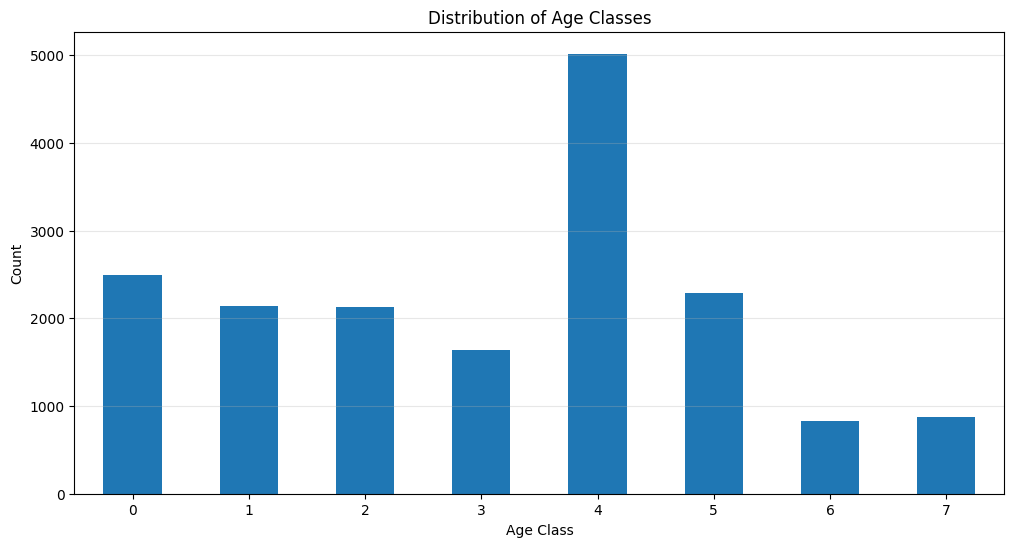

In [39]:
if len(data) > 0:
    print("\nSample data:")
    display(data)
    
    # Show age distribution
    plt.figure(figsize=(12, 6))
    data['age_class'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Age Classes')
    plt.xlabel('Age Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

### Extract faces

In [40]:
creator.extract_faces_archive()

data\faces already exists. Skipping extraction.


### Generate dataset

In [41]:
creator.create_yolo_dataset(train_folds=[0, 1, 2, 3], val_fold=4, output_dir="data/age_dataset_tune")

✅ data/age_dataset_tune already complete. Skipping...


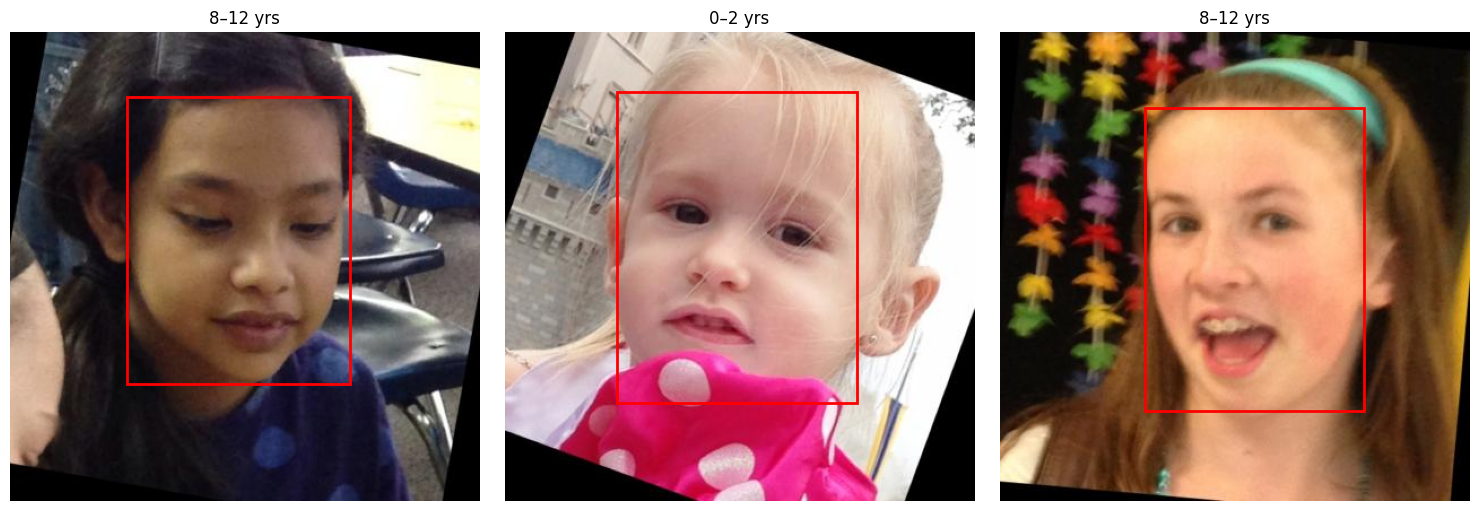

In [42]:
show_random_samples_with_bbox(image_dir="data/age_dataset_tune/images/val",label_dir="data/age_dataset_tune/labels/val",creator=creator,n=3)

## Hyperparameter tuning

### Tune

In [43]:
if DOWNLOAD_OPTUNA_DB:
    db_path = f'{STORAGE}.db'
    if not os.path.exists(db_path):
        url = 'https://drive.google.com/uc?id=1dCQQHsswZilthnxTc1_kbQ8RvRYctXCs'
        gdown.download(url, db_path, quiet=False)
    else:
        print(f"File '{db_path}' already exists. Skipping download.")

File 'YOLO.db' already exists. Skipping download.


In [44]:
if RUN_OPTUNA:
    run_optuna_tuning_multi(
        base_dataset_dir='data/age_dataset_tune',
        model_sizes=MODEL_SIZES,
        model_versions=MODEL_VERSIONS, 
        imgsz=IMAGE_SIZE,
        n_trials=10 if not SPEEDRUN else 1, # TEMPDEV
        epochs_per_trial=30 if not SPEEDRUN else 1, # TEMPDEV
        device='0',
        output_base='runs/age_exp'
    )
else:
    print("Config RUN_OPTUNA is False")


📂 Evaluating dataset: data/age_dataset_tune\data.yaml

🧪 Tuning: YOLOv8-n on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-n: 0.0000

🧪 Tuning: YOLOv8-s on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-s: 0.0000

🧪 Tuning: YOLOv8-m on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-m: 0.0554

🧪 Tuning: YOLOv8-l on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-l: 0.1542

🧪 Tuning: YOLOv8-x on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-x: 0.0275

🧪 Tuning: YOLOv9-n on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv9-n: 0.0000

🧪 Tuning: YOLOv9-s on dataset age_dataset_tune
⏩ Skipping tuning: 1 

## Train

### Generate training dataset 

With different foldsplit than used in tuning

In [45]:
creator.create_yolo_dataset(train_folds=[0, 1, 2, 4], val_fold=3, output_dir="data/age_dataset_test")

✅ data/age_dataset_test already complete. Skipping...


In [46]:
default_train_params = {
    'imgsz': 416,
    'optimizer': 'AdamW',
    'val': False,
    'deterministic': False,
    'batch': 32 if not SPEEDRUN or not USE_MAX_BATCH else 0.9, # TEMPDEV
    'workers': 3, # TODO: TEMPDEV
    'fraction': 1.0 if not SPEEDRUN else 0.1 # TEMPDEV
}

### Model Sizes

In [47]:
if RUN_EXP_MODEL_SIZES:
    for size in MODEL_SIZES:
        run_multiple_trainings(
            data_yaml='data/age_dataset_test/data.yaml',
            extra_train_params=default_train_params,
            model_v='8',
            model_size=size,
            db_path=f'sqlite:///{STORAGE}.db',
            study_name='3 model size n', # For best params
            num_runs=5 if not SPEEDRUN else 2, # TEMPDEV
            epochs=30 if not SPEEDRUN else 2, # TEMPDEV
            device='0',
            project='runs/multi_runs',
            conf_threshold=0.25
        )
else:
    print("Config RUN_EXP_MODEL_SIZES is False")

Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr: 0.36773774679273874
  mosaic: 0.42703933080795287

Starting Run 1/2
Run 1: Using random seed 6355
Run 1: Using model yolov8n.pt

Run 1: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14552.30it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.33G reserved, 0.06G allocated, 7.61G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3012408       3.465         0.554         52.55         497.8        (1, 3, 416, 416)                    list
     3012408        6.93         0.608         43.68         196.4        (2, 3, 416, 416)                    list
     3012408       13.86         0.910         71.26         192.9        (4, 3, 416, 416)                    list
     3012408       27.72         1.409         40.55         189.9        (8, 3, 416, 416)                    list
     3012408       55.44         1.793         91.18         185.5       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 76 for CUDA:0 7.38G/8.00G (92%) 
train: Fast image access  (ping: 0.10.0 ms, read: 63.517.5 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14321.53it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 187.366.3 MB/s, size: 17.7 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 9804.00it/s] 


Plotting labels to runs\multi_runs\multi_run_20250502_234122_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007787094058572223), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250502_234122_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2       4.3G    0.03544      1.497      1.599          1        416: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2       4.3G    0.02841      1.051      1.293          1        416: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


                   all       2964       2964      0.147      0.118     0.0238    0.00453

2 epochs completed in 0.009 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250502_234122_run1\weights\last.pt, 6.2MB
Optimizer stripped from runs\multi_runs\multi_run_20250502_234122_run1\weights\best.pt, 6.2MB

Validating runs\multi_runs\multi_run_20250502_234122_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


                   all       2964       2964      0.147      0.118     0.0239    0.00454
Speed: 0.2ms preprocess, 0.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250502_234122_run1
Run 1: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250502_234122_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250502_234122_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_234122_run1\confusion_matrix
Processing time: 41.33 seconds

Run 1 Results (using last.pt weights):
  Training Time: 83.58 seconds (0.02 hours)
  Accuracy: 0.0024 (7/2964)
  YOLO Metrics:
    precision(B): 0.1474
    recall(B): 0.1185
    mAP50(B): 0.0238
    mAP50-95(B): 0.0045

Starting Run 2/2
Run 2: Using random seed 9619
Run 2: Using model yolov8n.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250502_234122_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12835.07it/s]

AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.


AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.47G reserved, 0.15G allocated, 7.38G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3012408       3.465         0.606         23.32         40.77        (1, 3, 416, 416)                    list
     3012408        6.93         0.667         33.74         68.99        (2, 3, 416, 416)                    list
     3012408       13.86         0.948         30.78         67.02        (4, 3, 416, 416)                    list
     3012408       27.72         1.470         44.52         90.47        (8, 3, 416, 416)                    list
     3012408       55.44         1.864         78.37          50.4       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 74 for CUDA:0 7.60G/8.00G (95%) 
train: Fast image access  (ping: 0.10.0 ms, read: 61.316.6 MB/s, size: 20.1 KB)


train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12713.42it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 225.460.9 MB/s, size: 18.7 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 9958.04it/s]


Plotting labels to runs\multi_runs\multi_run_20250502_234122_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000758217053071506), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250502_234122_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2       4.1G    0.03535      1.494      1.604         56        416: 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.07G    0.02942      1.031      1.322         61        416: 100%|██████████| 20/20 [00:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:17<00:00,  1.23it/s]


                   all       2964       2964     0.0155       0.28     0.0128    0.00228

2 epochs completed in 0.008 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250502_234122_run2\weights\last.pt, 6.2MB
Optimizer stripped from runs\multi_runs\multi_run_20250502_234122_run2\weights\best.pt, 6.2MB

Validating runs\multi_runs\multi_run_20250502_234122_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


                   all       2964       2964     0.0155      0.281     0.0128    0.00229
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250502_234122_run2
Run 2: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250502_234122_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250502_234122_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_234122_run2\confusion_matrix
Processing time: 41.60 seconds

Run 2 Results (using last.pt weights):
  Training Time: 78.34 seconds (0.02 hours)
  Accuracy: 0.0000 (0/2964)
  YOLO Metrics:
    precision(B): 0.0155
    recall(B): 0.2804
    mAP50(B): 0.0128
    mAP50-95(B): 0.0023

Individual run values for key metrics:
  Training Time (seconds): [83.57678627967834, 78.34015846252441]
  accuracy: [0.0023616734143049934, 0.0]
  metrics/precision(B): [0.14736, 0.01546]
  metrics/recall(B): [0.11848, 0.28042]
  metrics/mAP50(B): [0.02383, 0.01278]
  metrics/mAP50-95(B): [0.00453, 0.00228]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 351.61 seconds (0.10 hours)
  Average Training Time: 80.96 seconds (0.02 hours) ± 2.62 seconds
  Accuracy: 0.0012 +/- 0.0017
  YOLO Metrics:
    precision(B): 0.0814 +/- 0.0933
    recall(B): 0.1995 +/- 0.1145
    mAP50(B): 0.0183 +/- 0.0078
    mAP50-95(B): 0

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_234122_aggregate\final_confusion_matrix
Processing time: 41.85 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250502_234122_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250502_234122_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13757.25it/s]

AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.


AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.59G reserved, 0.23G allocated, 7.18G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.007         45.67         223.9        (1, 3, 416, 416)                    list
    11138696       24.22         1.181         50.69         181.7        (2, 3, 416, 416)                    list
    11138696       48.44         1.671         43.01         163.3        (4, 3, 416, 416)                    list
    11138696       96.88         2.024         80.83         192.5        (8, 3, 416, 416)                    list
    11138696       193.8         2.963         36.29         160.7       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 39 for CUDA:0 6.74G/8.00G (84%) 
train: Fast image access  (ping: 0.00.0 ms, read: 56.918.3 MB/s, size: 19.0 KB)


train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13890.91it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 128.743.9 MB/s, size: 20.1 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 10917.11it/s]


Plotting labels to runs\multi_runs\multi_run_20250502_234800_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007992017586429387), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250502_234800_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.84G    0.03735      1.316      1.647          2        416: 100%|██████████| 38/38 [00:07<00:00,  4.82it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.84G      0.033      0.829      1.403          3        416: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


                   all       2964       2964      0.136      0.556      0.217     0.0999

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250502_234800_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250502_234800_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250502_234800_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


                   all       2964       2964      0.136      0.556      0.216     0.0988
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250502_234800_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250502_234800_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250502_234800_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_234800_run1\confusion_matrix
Processing time: 45.09 seconds

Run 1 Results (using last.pt weights):
  Training Time: 90.84 seconds (0.03 hours)
  Accuracy: 0.0854 (253/2964)
  YOLO Metrics:
    precision(B): 0.1361
    recall(B): 0.5559
    mAP50(B): 0.2174
    mAP50-95(B): 0.0999

Starting Run 2/2
Run 2: Using random seed 1384
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250502_234800_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13450.89it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.59G reserved, 0.34G allocated, 7.07G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.063         40.84         62.96        (1, 3, 416, 416)                    list
    11138696       24.22         1.239         59.06         111.7        (2, 3, 416, 416)                    list
    11138696       48.44         1.684         49.67         66.74        (4, 3, 416, 416)                    list
    11138696       96.88         2.051         51.34          37.1        (8, 3, 416, 416)                    list
    11138696       193.8         2.995         50.13         57.98       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 39 for CUDA:0 6.84G/8.00G (85%) 
train: Fast image access  (ping: 0.10.0 ms, read: 46.49.7 MB

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13142.22it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 100.030.8 MB/s, size: 17.3 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11751.69it/s]


Plotting labels to runs\multi_runs\multi_run_20250502_234800_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007992017586429387), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250502_234800_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.89G    0.03816      1.392      1.666          2        416: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.89G    0.03214     0.8294      1.389          3        416: 100%|██████████| 38/38 [00:07<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.94it/s]


                   all       2964       2964      0.396      0.395       0.25      0.103

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250502_234800_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250502_234800_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250502_234800_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


                   all       2964       2964      0.395      0.398       0.25      0.103
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250502_234800_run2
Run 2: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250502_234800_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250502_234800_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_234800_run2\confusion_matrix
Processing time: 48.15 seconds

Run 2 Results (using last.pt weights):
  Training Time: 89.47 seconds (0.02 hours)
  Accuracy: 0.3249 (963/2964)
  YOLO Metrics:
    precision(B): 0.3955
    recall(B): 0.3951
    mAP50(B): 0.2505
    mAP50-95(B): 0.1031

Individual run values for key metrics:
  Training Time (seconds): [90.83603167533875, 89.47306728363037]
  accuracy: [0.08535762483130904, 0.3248987854251012]
  metrics/precision(B): [0.13613, 0.39554]
  metrics/recall(B): [0.5559, 0.39512]
  metrics/mAP50(B): [0.21737, 0.25046]
  metrics/mAP50-95(B): [0.0999, 0.10308]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 374.36 seconds (0.10 hours)
  Average Training Time: 90.15 seconds (0.03 hours) ± 0.68 seconds
  Accuracy: 0.2051 +/- 0.1694
  YOLO Metrics:
    precision(B): 0.2658 +/- 0.1834
    recall(B): 0.4755 +/- 0.1137
    mAP50(B): 0.2339 +/- 0.0234
    m

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_234800_aggregate\final_confusion_matrix
Processing time: 48.63 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250502_234800_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250502_234800_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13442.48it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.61G reserved, 0.55G allocated, 6.84G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25860952       33.41         1.674         90.44           173        (1, 3, 416, 416)                    list
    25860952       66.83         1.881         51.16         221.7        (2, 3, 416, 416)                    list
    25860952       133.7         2.426         83.37         175.6        (4, 3, 416, 416)                    list
    25860952       267.3         3.311         51.03           173        (8, 3, 416, 416)                    list
    25860952       534.6         5.027         66.96         193.9       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 20 for CUDA:0 7.11G/8.00G (89%) 
train: Fast image access  (ping: 0.10.0 ms, read: 48.99.1 MB

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13660.13it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 186.856.7 MB/s, size: 15.7 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12594.88it/s]


Plotting labels to runs\multi_runs\multi_run_20250502_235508_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0006147705835714913), 83 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250502_235508_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.67G    0.03526      1.062      1.558          5        416: 100%|██████████| 73/73 [00:16<00:00,  4.33it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.67G     0.0334     0.8716      1.439          6        416: 100%|██████████| 73/73 [00:14<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:23<00:00,  3.14it/s]


                   all       2964       2964      0.106      0.373      0.162     0.0959

2 epochs completed in 0.017 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250502_235508_run1\weights\last.pt, 52.0MB
Optimizer stripped from runs\multi_runs\multi_run_20250502_235508_run1\weights\best.pt, 52.0MB

Validating runs\multi_runs\multi_run_20250502_235508_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:22<00:00,  3.30it/s]


                   all       2964       2964      0.107      0.374      0.164     0.0967
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250502_235508_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250502_235508_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250502_235508_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_235508_run1\confusion_matrix
Processing time: 53.43 seconds

Run 1 Results (using last.pt weights):
  Training Time: 117.72 seconds (0.03 hours)
  Accuracy: 0.1555 (461/2964)
  YOLO Metrics:
    precision(B): 0.1064
    recall(B): 0.3733
    mAP50(B): 0.1621
    mAP50-95(B): 0.0959

Starting Run 2/2
Run 2: Using random seed 8063
Run 2: Using model yolov8m.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250502_235508_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbo

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12227.18it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 1.00G reserved, 0.85G allocated, 6.15G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25860952       33.41         1.814         75.93         100.2        (1, 3, 416, 416)                    list
    25860952       66.83         2.137         32.28         35.44        (2, 3, 416, 416)                    list
    25860952       133.7         2.670          32.6          51.8        (4, 3, 416, 416)                    list
    25860952       267.3         3.450         35.44         56.94        (8, 3, 416, 416)                    list
    25860952       534.6         5.161          66.8         75.57       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 19 for CUDA:0 7.69G/8.00G (96%) 
train: Fast image access  (ping: 0.10.0 ms, read: 53.211.7 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13185.88it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 186.656.2 MB/s, size: 17.2 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12667.98it/s]


Plotting labels to runs\multi_runs\multi_run_20250502_235508_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005840320543929168), 83 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250502_235508_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.68G    0.03589       1.08      1.569          1        416: 100%|██████████| 77/77 [00:16<00:00,  4.66it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.68G    0.03247     0.8725      1.416          1        416: 100%|██████████| 77/77 [00:15<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.14it/s]


                   all       2964       2964      0.054      0.399      0.102      0.049

2 epochs completed in 0.017 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250502_235508_run2\weights\last.pt, 52.0MB
Optimizer stripped from runs\multi_runs\multi_run_20250502_235508_run2\weights\best.pt, 52.0MB

Validating runs\multi_runs\multi_run_20250502_235508_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 92 layers, 25,844,392 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.28it/s]


                   all       2964       2964     0.0541      0.398      0.101     0.0489
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250502_235508_run2
Run 2: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250502_235508_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250502_235508_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_235508_run2\confusion_matrix
Processing time: 55.49 seconds

Run 2 Results (using last.pt weights):
  Training Time: 118.34 seconds (0.03 hours)
  Accuracy: 0.3209 (951/2964)
  YOLO Metrics:
    precision(B): 0.0540
    recall(B): 0.3988
    mAP50(B): 0.1017
    mAP50-95(B): 0.0490

Individual run values for key metrics:
  Training Time (seconds): [117.71593999862671, 118.33903312683105]
  accuracy: [0.15553306342780027, 0.3208502024291498]
  metrics/precision(B): [0.1064, 0.05404]
  metrics/recall(B): [0.37326, 0.39884]
  metrics/mAP50(B): [0.16213, 0.10168]
  metrics/mAP50-95(B): [0.09586, 0.04904]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 469.95 seconds (0.13 hours)
  Average Training Time: 118.03 seconds (0.03 hours) ± 0.31 seconds
  Accuracy: 0.2382 +/- 0.1169
  YOLO Metrics:
    precision(B): 0.0802 +/- 0.0370
    recall(B): 0.3861 +/- 0.0181
    mAP50(B): 0.1319 +/- 0.0427


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250502_235508_aggregate\final_confusion_matrix
Processing time: 54.28 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250502_235508_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250502_235508_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13276.40it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 1.15G reserved, 1.08G allocated, 5.77G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    43636008        69.9         2.345         66.75         158.6        (1, 3, 416, 416)                    list
    43636008       139.8         2.871         76.29         191.5        (2, 3, 416, 416)                    list
    43636008       279.6         3.760         52.71           156        (4, 3, 416, 416)                    list
    43636008       559.2         5.169         64.53         158.6        (8, 3, 416, 416)                    list
    43636008        1118         7.392         91.79         178.1       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 8 for CUDA:0 7.13G/8.00G (89%) 
train: Fast image access  (ping: 0.10.0 ms, read: 44.111.9 MB

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14431.02it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 132.748.0 MB/s, size: 17.9 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11866.39it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_000357_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0006557552891429241), 103 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_000357_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.94G    0.03866      1.059      1.588          7        416: 100%|██████████| 181/181 [00:31<00:00,  5.78it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      2.94G    0.03676     0.9315      1.503          6        416: 100%|██████████| 181/181 [00:27<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 186/186 [00:31<00:00,  5.85it/s]


                   all       2964       2964      0.196     0.0993     0.0319     0.0122

2 epochs completed in 0.027 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_000357_run1\weights\last.pt, 87.6MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_000357_run1\weights\best.pt, 87.6MB

Validating runs\multi_runs\multi_run_20250503_000357_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 112 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 186/186 [00:28<00:00,  6.45it/s]


                   all       2964       2964      0.196     0.0993      0.032     0.0122
Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_000357_run1
Run 1: Training completed in 0.04 hours. Results saved to runs/multi_runs\multi_run_20250503_000357_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_000357_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_000357_run1\confusion_matrix
Processing time: 70.04 seconds

Run 1 Results (using last.pt weights):
  Training Time: 161.12 seconds (0.04 hours)
  Accuracy: 0.0614 (182/2964)
  YOLO Metrics:
    precision(B): 0.1956
    recall(B): 0.0993
    mAP50(B): 0.0319
    mAP50-95(B): 0.0122

Starting Run 2/2
Run 2: Using random seed 9091
Run 2: Using model yolov8l.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8l.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_000357_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbo

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13186.16it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 1.61G reserved, 1.22G allocated, 5.18G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    43636008        69.9         2.858         124.1         60.08        (1, 3, 416, 416)                    list
    43636008       139.8         3.307          42.9         42.12        (2, 3, 416, 416)                    list
    43636008       279.6         3.978         40.49         50.53        (4, 3, 416, 416)                    list
    43636008       559.2         5.484         49.94         66.55        (8, 3, 416, 416)                    list
    43636008        1118         7.711         88.32         118.4       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 7 for CUDA:0 7.75G/8.00G (97%) 
train: Fast image access  (ping: 0.10.0 ms, read: 53.813.2 MB

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13195.55it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 162.343.6 MB/s, size: 17.9 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12674.88it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_000357_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0006455091127500659), 103 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_000357_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2       2.8G    0.03722      1.116      1.651          4        416: 100%|██████████| 207/207 [00:34<00:00,  5.92it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2       2.8G      0.036     0.9953      1.612          3        416: 100%|██████████| 207/207 [00:29<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 212/212 [00:31<00:00,  6.82it/s]


                   all       2964       2964      0.154      0.513      0.157     0.0826

2 epochs completed in 0.028 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_000357_run2\weights\last.pt, 87.6MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_000357_run2\weights\best.pt, 87.6MB

Validating runs\multi_runs\multi_run_20250503_000357_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 112 layers, 43,612,776 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 212/212 [00:28<00:00,  7.47it/s]


                   all       2964       2964      0.154      0.513      0.157     0.0825
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_000357_run2
Run 2: Training completed in 0.05 hours. Results saved to runs/multi_runs\multi_run_20250503_000357_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_000357_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_000357_run2\confusion_matrix
Processing time: 66.43 seconds

Run 2 Results (using last.pt weights):
  Training Time: 165.51 seconds (0.05 hours)
  Accuracy: 0.2706 (802/2964)
  YOLO Metrics:
    precision(B): 0.1544
    recall(B): 0.5130
    mAP50(B): 0.1568
    mAP50-95(B): 0.0826

Individual run values for key metrics:
  Training Time (seconds): [161.1167595386505, 165.51037621498108]
  accuracy: [0.06140350877192982, 0.27058029689608637]
  metrics/precision(B): [0.19559, 0.15437]
  metrics/recall(B): [0.09934, 0.513]
  metrics/mAP50(B): [0.03192, 0.1568]
  metrics/mAP50-95(B): [0.01222, 0.0826]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 611.42 seconds (0.17 hours)
  Average Training Time: 163.31 seconds (0.05 hours) ± 2.20 seconds
  Accuracy: 0.1660 +/- 0.1479
  YOLO Metrics:
    precision(B): 0.1750 +/- 0.0291
    recall(B): 0.3062 +/- 0.2925
    mAP50(B): 0.0944 +/- 0.0883
   

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_000357_aggregate\final_confusion_matrix
Processing time: 67.17 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_000357_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_000357_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13553.58it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 2.29G reserved, 1.89G allocated, 3.81G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    68160312       109.1         3.561         74.18         228.7        (1, 3, 416, 416)                    list
    68160312       218.1         4.192         44.96         216.7        (2, 3, 416, 416)                    list
    68160312       436.3         5.253          50.4         208.9        (4, 3, 416, 416)                    list
    68160312       872.6         6.696          84.3         216.8        (8, 3, 416, 416)                    list
    68160312        1745         9.810         113.4         276.4       (16, 3, 416, 416)                    list
WARNING AutoBatch: batch=0 outside safe range, using default batch-size 16.
AutoBatch: Using batch-size 16 for CUDA:0 14.

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 11798.77it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 170.520.7 MB/s, size: 19.2 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12209.01it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_001521_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0006557552891429241), 103 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_001521_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      5.97G    0.03693      1.166      1.699          6        416: 100%|██████████| 91/91 [00:34<00:00,  2.67it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      6.44G    0.03496     0.9514      1.555          6        416: 100%|██████████| 91/91 [00:32<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [02:00<00:00,  1.30s/it]


                   all       2964       2964     0.0237      0.156     0.0259     0.0121

2 epochs completed in 0.054 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_001521_run1\weights\last.pt, 136.7MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_001521_run1\weights\best.pt, 136.7MB

Validating runs\multi_runs\multi_run_20250503_001521_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 112 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:36<00:00,  2.58it/s]


                   all       2964       2964     0.0236      0.156     0.0263     0.0124
Speed: 0.1ms preprocess, 6.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_001521_run1
Run 1: Training completed in 0.07 hours. Results saved to runs/multi_runs\multi_run_20250503_001521_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_001521_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_001521_run1\confusion_matrix
Processing time: 65.69 seconds

Run 1 Results (using last.pt weights):
  Training Time: 268.84 seconds (0.07 hours)
  Accuracy: 0.0547 (162/2964)
  YOLO Metrics:
    precision(B): 0.0237
    recall(B): 0.1562
    mAP50(B): 0.0259
    mAP50-95(B): 0.0121

Starting Run 2/2
Run 2: Using random seed 3688
Run 2: Using model yolov8x.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_001521_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbo

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13351.74it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 2.80G reserved, 1.87G allocated, 3.33G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    68160312       109.1         4.240         66.14         35.27        (1, 3, 416, 416)                    list
    68160312       218.1         4.685         53.98         36.73        (2, 3, 416, 416)                    list
    68160312       436.3         5.824         44.88         65.34        (4, 3, 416, 416)                    list
    68160312       872.6         7.309         60.14         117.3        (8, 3, 416, 416)                    list
    68160312        1745        10.320         116.9           284       (16, 3, 416, 416)                    list
WARNING AutoBatch: batch=-1 outside safe range, using default batch-size 16.
AutoBatch: Using batch-size 16 for CUDA:0 15

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14096.68it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 182.247.6 MB/s, size: 17.1 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12283.70it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_001521_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0006557552891429241), 103 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_001521_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      6.24G    0.03698      1.158      1.758          6        416: 100%|██████████| 91/91 [00:34<00:00,  2.66it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      6.75G    0.03444     0.9626      1.661          6        416: 100%|██████████| 91/91 [00:31<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [01:02<00:00,  1.49it/s]


                   all       2964       2964      0.359       0.33      0.117     0.0661

2 epochs completed in 0.038 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_001521_run2\weights\last.pt, 136.7MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_001521_run2\weights\best.pt, 136.7MB

Validating runs\multi_runs\multi_run_20250503_001521_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 112 layers, 68,131,272 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:42<00:00,  2.19it/s]


                   all       2964       2964      0.359      0.331      0.117     0.0661
Speed: 0.1ms preprocess, 6.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_001521_run2
Run 2: Training completed in 0.06 hours. Results saved to runs/multi_runs\multi_run_20250503_001521_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_001521_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_001521_run2\confusion_matrix
Processing time: 67.32 seconds

Run 2 Results (using last.pt weights):
  Training Time: 216.61 seconds (0.06 hours)
  Accuracy: 0.3013 (893/2964)
  YOLO Metrics:
    precision(B): 0.3591
    recall(B): 0.3303
    mAP50(B): 0.1166
    mAP50-95(B): 0.0661

Individual run values for key metrics:
  Training Time (seconds): [268.8400809764862, 216.6058428287506]
  accuracy: [0.05465587044534413, 0.30128205128205127]
  metrics/precision(B): [0.02373, 0.35906]
  metrics/recall(B): [0.15625, 0.33034]
  metrics/mAP50(B): [0.02586, 0.1166]
  metrics/mAP50-95(B): [0.01206, 0.06614]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 773.22 seconds (0.21 hours)
  Average Training Time: 242.72 seconds (0.07 hours) ± 26.12 seconds
  Accuracy: 0.1780 +/- 0.1744
  YOLO Metrics:
    precision(B): 0.1914 +/- 0.2371
    recall(B): 0.2433 +/- 0.1231
    mAP50(B): 0.0712 +/- 0.0642


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_001521_aggregate\final_confusion_matrix
Processing time: 66.43 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_001521_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_001521_aggregate


### Data Augmentation

In [48]:
if RUN_EXP_DATA_AUGMENTATION:
    augmentation_combinations = [
        {
            'hsv_h': 0.015,
            'hsv_s': 0.2,
            'hsv_v': 0.2, 
            'degrees': 20.0,
            'translate': 0.01,
            'scale': 0.2,
            'fliplr': 0.2,
            'mosaic': 0.2
        },
        {
            'hsv_h': 0.02,
            'hsv_s': 0.7,
            'hsv_v': 0.5, 
            'degrees': 35.0,
            'translate': 0.08,
            'scale': 0.4,
            'fliplr': 0.5,
            'mosaic': 0.4
        },
        {
            'hsv_h': 0.03,
            'hsv_s': 0.9,
            'hsv_v': 0.7, 
            'degrees': 50.0,
            'translate': 0.15,
            'scale': 0.6,
            'fliplr': 0.5,
            'mosaic': 0.6
        }
    ]

    for i, combo in enumerate(augmentation_combinations, start=1):
        for close_mosaic_val in [10, 30]:
            experiment_params = {
                **default_train_params,
                **combo,
                'close_mosaic': close_mosaic_val
            }

            print(f"\n=== Running augmentation combo {i} with close_mosaic={close_mosaic_val} ===")

            run_multiple_trainings(
                data_yaml='data/age_dataset_test/data.yaml',
                extra_train_params=experiment_params,
                model_v='8',
                model_size='s',
                db_path=f'sqlite:///{STORAGE}.db',
                study_name='3 model size n', # For best params
                num_runs=5 if not SPEEDRUN else 2, # TEMPDEV
                epochs=30 if not SPEEDRUN else 2, # TEMPDEV
                device='0',
                project='runs/multi_runs',
                conf_threshold=0.25
            )
else:
    print("Config RUN_EXP_DATA_AUGMENTATION is False")


=== Running augmentation combo 1 with close_mosaic=10 ===
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr: 0.36773774679273874
  mosaic: 0.42703933080795287

Starting Run 1/2
Run 1: Using random seed 8110
Run 1: Using model yolov8s.pt

Run 1: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultraly

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12553.63it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 2.87G reserved, 1.97G allocated, 3.16G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         2.093         49.69         69.95        (1, 3, 416, 416)                    list
    11138696       24.22         2.135         47.72         84.95        (2, 3, 416, 416)                    list
    11138696       48.44         2.271         33.25         35.34        (4, 3, 416, 416)                    list
    11138696       96.88         2.395         31.16         16.33        (8, 3, 416, 416)                    list
    11138696       193.8         3.186         34.55         48.69       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 14 for CUDA:0 7.82G/8.00G (98%) 
train: Fast image access  (ping: 0.00.0 ms, read: 56.621.6 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12770.94it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 126.649.0 MB/s, size: 16.8 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 13478.79it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_002925_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007172323475000731), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_002925_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      1.87G    0.03637       1.01      1.591          3        416: 100%|██████████| 104/104 [00:12<00:00,  8.13it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      1.87G    0.03171     0.7859      1.408          5        416: 100%|██████████| 104/104 [00:10<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [00:22<00:00,  4.74it/s]


                   all       2964       2964      0.158      0.474      0.284      0.144

2 epochs completed in 0.014 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_002925_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_002925_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_002925_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 106/106 [00:20<00:00,  5.25it/s]


                   all       2964       2964       0.16      0.475      0.284      0.144
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_002925_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_002925_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_002925_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_002925_run1\confusion_matrix
Processing time: 42.50 seconds

Run 1 Results (using last.pt weights):
  Training Time: 100.60 seconds (0.03 hours)
  Accuracy: 0.3381 (1002/2964)
  YOLO Metrics:
    precision(B): 0.1584
    recall(B): 0.4736
    mAP50(B): 0.2841
    mAP50-95(B): 0.1439

Starting Run 2/2
Run 2: Using random seed 5153
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_002925_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verb

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14442.85it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.95G reserved, 0.40G allocated, 6.65G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.292         39.04         46.85        (1, 3, 416, 416)                    list
    11138696       24.22         1.334         23.35         63.24        (2, 3, 416, 416)                    list
    11138696       48.44         1.785         35.31         84.08        (4, 3, 416, 416)                    list
    11138696       96.88         2.145         84.79         49.95        (8, 3, 416, 416)                    list
    11138696       193.8         3.089         37.35         31.74       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 7.34G/8.00G (92%) 
train: Fast image access  (ping: 0.10.0 ms, read: 45.113.8 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14550.48it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 180.233.4 MB/s, size: 17.6 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11769.58it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_002925_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_002925_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.17G    0.03788      1.185      1.711          5        416: 100%|██████████| 37/37 [00:07<00:00,  4.66it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.22G    0.02943     0.7609      1.338          5        416: 100%|██████████| 37/37 [00:07<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]


                   all       2964       2964     0.0858       0.34      0.135     0.0495

2 epochs completed in 0.010 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_002925_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_002925_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_002925_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16<00:00,  2.25it/s]


                   all       2964       2964     0.0859      0.339      0.133     0.0489
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_002925_run2
Run 2: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_002925_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_002925_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_002925_run2\confusion_matrix
Processing time: 41.95 seconds

Run 2 Results (using last.pt weights):
  Training Time: 85.68 seconds (0.02 hours)
  Accuracy: 0.2443 (724/2964)
  YOLO Metrics:
    precision(B): 0.0858
    recall(B): 0.3401
    mAP50(B): 0.1351
    mAP50-95(B): 0.0495

Individual run values for key metrics:
  Training Time (seconds): [100.5978491306305, 85.68190455436707]
  accuracy: [0.33805668016194335, 0.24426450742240216]
  metrics/precision(B): [0.15836, 0.08575]
  metrics/recall(B): [0.47362, 0.34006]
  metrics/mAP50(B): [0.2841, 0.13512]
  metrics/mAP50-95(B): [0.14391, 0.04948]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 365.09 seconds (0.10 hours)
  Average Training Time: 93.14 seconds (0.03 hours) ± 7.46 seconds
  Accuracy: 0.2912 +/- 0.0663
  YOLO Metrics:
    precision(B): 0.1221 +/- 0.0513
    recall(B): 0.4068 +/- 0.0944
    mAP50(B): 0.2096 +/- 0.1053
   

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_002925_aggregate\final_confusion_matrix
Processing time: 45.63 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_002925_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_002925_aggregate

=== Running augmentation combo 1 with close_mosaic=30 ===
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  transla

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14589.99it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.66G reserved, 0.43G allocated, 6.91G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         0.994         29.79         67.56        (1, 3, 416, 416)                    list
    11138696       24.22         1.170          47.7          50.1        (2, 3, 416, 416)                    list
    11138696       48.44         1.613         51.37         83.83        (4, 3, 416, 416)                    list
    11138696       96.88         1.990         34.74         26.89        (8, 3, 416, 416)                    list
    11138696       193.8         2.909         50.02         34.34       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 7.02G/8.00G (88%) 
train: Fast image access  (ping: 0.10.1 ms, read: 34.612.1 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14395.27it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 180.659.0 MB/s, size: 17.1 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12001.81it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_003621_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_003621_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.12G    0.03999      1.682      1.804          5        416: 100%|██████████| 37/37 [00:07<00:00,  5.02it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.17G    0.03095      0.736      1.366          5        416: 100%|██████████| 37/37 [00:07<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


                   all       2964       2964      0.218      0.269     0.0979      0.033

2 epochs completed in 0.010 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_003621_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_003621_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_003621_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


                   all       2964       2964      0.219      0.268     0.0986     0.0332
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_003621_run1
Run 1: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_003621_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_003621_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_003621_run1\confusion_matrix
Processing time: 42.08 seconds

Run 1 Results (using last.pt weights):
  Training Time: 86.99 seconds (0.02 hours)
  Accuracy: 0.1471 (436/2964)
  YOLO Metrics:
    precision(B): 0.2183
    recall(B): 0.2685
    mAP50(B): 0.0979
    mAP50-95(B): 0.0330

Starting Run 2/2
Run 2: Using random seed 5560
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_003621_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 15084.08it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.54G reserved, 0.34G allocated, 7.12G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.118          49.8         52.75        (1, 3, 416, 416)                    list
    11138696       24.22         1.294         43.34         66.39        (2, 3, 416, 416)                    list
    11138696       48.44         1.701          54.4         78.27        (4, 3, 416, 416)                    list
    11138696       96.88         2.080         24.35         30.88        (8, 3, 416, 416)                    list
    11138696       193.8         3.003         34.04          49.7       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 6.85G/8.00G (86%) 
train: Fast image access  (ping: 0.10.0 ms, read: 74.416.5 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14397.19it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 186.355.2 MB/s, size: 15.8 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12609.05it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_003621_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_003621_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.17G    0.03882      1.346      1.754          5        416: 100%|██████████| 37/37 [00:07<00:00,  4.98it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.22G     0.0303     0.7778      1.363          5        416: 100%|██████████| 37/37 [00:07<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:21<00:00,  1.73it/s]


                   all       2964       2964     0.0926      0.633      0.209     0.0856

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_003621_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_003621_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_003621_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:21<00:00,  1.80it/s]


                   all       2964       2964     0.0925      0.632      0.212      0.087
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_003621_run2
Run 2: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_003621_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_003621_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_003621_run2\confusion_matrix
Processing time: 42.13 seconds

Run 2 Results (using last.pt weights):
  Training Time: 92.85 seconds (0.03 hours)
  Accuracy: 0.3502 (1038/2964)
  YOLO Metrics:
    precision(B): 0.0926
    recall(B): 0.6331
    mAP50(B): 0.2092
    mAP50-95(B): 0.0856

Individual run values for key metrics:
  Training Time (seconds): [86.98660397529602, 92.85440874099731]
  accuracy: [0.14709851551956815, 0.35020242914979755]
  metrics/precision(B): [0.21833, 0.09256]
  metrics/recall(B): [0.2685, 0.63312]
  metrics/mAP50(B): [0.09787, 0.20921]
  metrics/mAP50-95(B): [0.033, 0.08557]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 358.44 seconds (0.10 hours)
  Average Training Time: 89.92 seconds (0.02 hours) ± 2.93 seconds
  Accuracy: 0.2487 +/- 0.1436
  YOLO Metrics:
    precision(B): 0.1554 +/- 0.0889
    recall(B): 0.4508 +/- 0.2578
    mAP50(B): 0.1535 +/- 0.0787
    

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_003621_aggregate\final_confusion_matrix
Processing time: 42.62 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_003621_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_003621_aggregate

=== Running augmentation combo 2 with close_mosaic=10 ===
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  transla

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14467.57it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.61G reserved, 0.45G allocated, 6.94G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         0.998         33.09          60.1        (1, 3, 416, 416)                    list
    11138696       24.22         1.174         82.08         85.81        (2, 3, 416, 416)                    list
    11138696       48.44         1.615         52.41         82.94        (4, 3, 416, 416)                    list
    11138696       96.88         1.858         69.91         130.1        (8, 3, 416, 416)                    list
    11138696       193.8         2.825         28.55         35.83       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 43 for CUDA:0 7.05G/8.00G (88%) 
train: Fast image access  (ping: 0.10.0 ms, read: 29.33.2 MB

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14445.19it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 168.236.0 MB/s, size: 16.1 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11560.29it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_004306_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004405855848929021), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_004306_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.03G    0.04162      1.437      1.869         44        416: 100%|██████████| 34/34 [00:07<00:00,  4.30it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.04G    0.03316     0.8855      1.469         39        416: 100%|██████████| 34/34 [00:06<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:18<00:00,  1.86it/s]


                   all       2964       2964      0.131      0.734      0.177     0.0926

2 epochs completed in 0.010 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_004306_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_004306_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_004306_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:17<00:00,  1.95it/s]


                   all       2964       2964      0.131       0.74      0.174     0.0915
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_004306_run1
Run 1: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_004306_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_004306_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_004306_run1\confusion_matrix
Processing time: 50.33 seconds

Run 1 Results (using last.pt weights):
  Training Time: 86.47 seconds (0.02 hours)
  Accuracy: 0.3293 (976/2964)
  YOLO Metrics:
    precision(B): 0.1305
    recall(B): 0.7338
    mAP50(B): 0.1767
    mAP50-95(B): 0.0926

Starting Run 2/2
Run 2: Using random seed 4635
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_004306_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14471.82it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.66G reserved, 0.34G allocated, 7.00G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.181         33.94          66.3        (1, 3, 416, 416)                    list
    11138696       24.22         1.357         59.64         73.34        (2, 3, 416, 416)                    list
    11138696       48.44         1.736         36.24         80.27        (4, 3, 416, 416)                    list
    11138696       96.88         2.093         83.27         116.6        (8, 3, 416, 416)                    list
    11138696       193.8         3.043         23.12         46.38       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 6.95G/8.00G (87%) 
train: Fast image access  (ping: 0.00.0 ms, read: 50.115.1 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14865.17it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 197.553.5 MB/s, size: 17.8 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11466.41it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_004306_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_004306_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.16G    0.04007      1.285      1.762          8        416: 100%|██████████| 37/37 [00:07<00:00,  5.13it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.22G    0.03329     0.8647      1.448          7        416: 100%|██████████| 37/37 [00:07<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


                   all       2964       2964      0.574     0.0758     0.0632     0.0284

2 epochs completed in 0.010 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_004306_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_004306_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_004306_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16<00:00,  2.31it/s]


                   all       2964       2964      0.574     0.0771     0.0633     0.0286
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_004306_run2
Run 2: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_004306_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_004306_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_004306_run2\confusion_matrix
Processing time: 40.58 seconds

Run 2 Results (using last.pt weights):
  Training Time: 84.67 seconds (0.02 hours)
  Accuracy: 0.1285 (381/2964)
  YOLO Metrics:
    precision(B): 0.5742
    recall(B): 0.0758
    mAP50(B): 0.0631
    mAP50-95(B): 0.0284

Individual run values for key metrics:
  Training Time (seconds): [86.46559643745422, 84.6712441444397]
  accuracy: [0.3292847503373819, 0.12854251012145748]
  metrics/precision(B): [0.13054, 0.57422]
  metrics/recall(B): [0.73384, 0.07583]
  metrics/mAP50(B): [0.17669, 0.06315]
  metrics/mAP50-95(B): [0.09259, 0.02843]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 367.39 seconds (0.10 hours)
  Average Training Time: 85.57 seconds (0.02 hours) ± 0.90 seconds
  Accuracy: 0.2289 +/- 0.1419
  YOLO Metrics:
    precision(B): 0.3524 +/- 0.3137
    recall(B): 0.4048 +/- 0.4653
    mAP50(B): 0.1199 +/- 0.0803
    

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_004306_aggregate\final_confusion_matrix
Processing time: 41.02 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_004306_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_004306_aggregate

=== Running augmentation combo 2 with close_mosaic=30 ===
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  transla

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12456.57it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.62G reserved, 0.46G allocated, 6.92G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.032         46.89         60.93        (1, 3, 416, 416)                    list
    11138696       24.22         1.206         70.97         77.71        (2, 3, 416, 416)                    list
    11138696       48.44         1.600         56.92         74.54        (4, 3, 416, 416)                    list
    11138696       96.88         1.992         81.29         135.4        (8, 3, 416, 416)                    list
    11138696       193.8         2.913          39.1         42.38       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 6.96G/8.00G (87%) 
train: Fast image access  (ping: 0.10.0 ms, read: 23.94.2 MB

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12540.65it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 190.652.4 MB/s, size: 16.7 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11915.67it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_004959_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_004959_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.13G    0.03994      1.243      1.744          8        416: 100%|██████████| 37/37 [00:07<00:00,  4.88it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.18G    0.03311     0.8697      1.436          7        416: 100%|██████████| 37/37 [00:07<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:21<00:00,  1.74it/s]


                   all       2964       2964     0.0736      0.442      0.147     0.0737

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_004959_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_004959_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_004959_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.96it/s]


                   all       2964       2964     0.0742      0.435      0.148     0.0742
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_004959_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_004959_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_004959_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_004959_run1\confusion_matrix
Processing time: 42.70 seconds

Run 1 Results (using last.pt weights):
  Training Time: 91.74 seconds (0.03 hours)
  Accuracy: 0.2088 (619/2964)
  YOLO Metrics:
    precision(B): 0.0736
    recall(B): 0.4417
    mAP50(B): 0.1473
    mAP50-95(B): 0.0737

Starting Run 2/2
Run 2: Using random seed 8079
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_004959_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14448.33it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.59G reserved, 0.36G allocated, 7.05G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.120         31.99         55.36        (1, 3, 416, 416)                    list
    11138696       24.22         1.298         53.64         101.3        (2, 3, 416, 416)                    list
    11138696       48.44         1.705         51.21         75.84        (4, 3, 416, 416)                    list
    11138696       96.88         2.062         84.41         131.4        (8, 3, 416, 416)                    list
    11138696       193.8         3.009         52.19         33.43       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 6.92G/8.00G (87%) 
train: Fast image access  (ping: 0.00.0 ms, read: 91.271.1 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14380.45it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 179.755.2 MB/s, size: 16.5 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11697.80it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_004959_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_004959_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.16G    0.04032      1.335      1.774          8        416: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.22G    0.03321     0.9045      1.452          7        416: 100%|██████████| 37/37 [00:07<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.93it/s]


                   all       2964       2964     0.0666      0.196     0.0621     0.0335

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_004959_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_004959_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_004959_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.22it/s]


                   all       2964       2964     0.0666      0.196     0.0627     0.0339
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_004959_run2
Run 2: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_004959_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_004959_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_004959_run2\confusion_matrix
Processing time: 45.35 seconds

Run 2 Results (using last.pt weights):
  Training Time: 87.48 seconds (0.02 hours)
  Accuracy: 0.0816 (242/2964)
  YOLO Metrics:
    precision(B): 0.0665
    recall(B): 0.1956
    mAP50(B): 0.0621
    mAP50-95(B): 0.0335

Individual run values for key metrics:
  Training Time (seconds): [91.73808860778809, 87.48281526565552]
  accuracy: [0.20883940620782726, 0.0816464237516869]
  metrics/precision(B): [0.07356, 0.06655]
  metrics/recall(B): [0.44169, 0.19557]
  metrics/mAP50(B): [0.14726, 0.06208]
  metrics/mAP50-95(B): [0.07369, 0.03349]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 365.69 seconds (0.10 hours)
  Average Training Time: 89.61 seconds (0.02 hours) ± 2.13 seconds
  Accuracy: 0.1452 +/- 0.0899
  YOLO Metrics:
    precision(B): 0.0701 +/- 0.0050
    recall(B): 0.3186 +/- 0.1740
    mAP50(B): 0.1047 +/- 0.0602
   

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_004959_aggregate\final_confusion_matrix
Processing time: 45.02 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_004959_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_004959_aggregate

=== Running augmentation combo 3 with close_mosaic=10 ===
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  transla

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14631.59it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.63G reserved, 0.44G allocated, 6.92G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.000          47.4          67.8        (1, 3, 416, 416)                    list
    11138696       24.22         1.179         65.41         64.29        (2, 3, 416, 416)                    list
    11138696       48.44         1.619          34.8         84.42        (4, 3, 416, 416)                    list
    11138696       96.88         1.994         44.92         26.64        (8, 3, 416, 416)                    list
    11138696       193.8         2.911          38.7         47.74       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 7.00G/8.00G (87%) 
train: Fast image access  (ping: 0.10.0 ms, read: 62.766.9 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14553.83it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 208.343.0 MB/s, size: 19.1 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12331.31it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_005655_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_005655_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.12G    0.04088      1.412      1.821          7        416: 100%|██████████| 37/37 [00:07<00:00,  4.95it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.18G    0.03426     0.9605      1.532         10        416: 100%|██████████| 37/37 [00:07<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


                   all       2964       2964     0.0619       0.41       0.11      0.046

2 epochs completed in 0.010 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_005655_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_005655_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_005655_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


                   all       2964       2964     0.0618       0.41      0.108     0.0451
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_005655_run1
Run 1: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_005655_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_005655_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_005655_run1\confusion_matrix
Processing time: 45.30 seconds

Run 1 Results (using last.pt weights):
  Training Time: 87.53 seconds (0.02 hours)
  Accuracy: 0.0773 (229/2964)
  YOLO Metrics:
    precision(B): 0.0619
    recall(B): 0.4103
    mAP50(B): 0.1096
    mAP50-95(B): 0.0460

Starting Run 2/2
Run 2: Using random seed 9108
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_005655_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14394.38it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.53G reserved, 0.35G allocated, 7.12G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.086         38.21         61.83        (1, 3, 416, 416)                    list
    11138696       24.22         1.262         31.48         47.43        (2, 3, 416, 416)                    list
    11138696       48.44         1.705         50.42         80.99        (4, 3, 416, 416)                    list
    11138696       96.88         1.925         84.94         108.6        (8, 3, 416, 416)                    list
    11138696       193.8         2.938         37.31         45.46       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 41 for CUDA:0 6.77G/8.00G (85%) 
train: Fast image access  (ping: 0.00.0 ms, read: 53.016.6 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14576.69it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 150.137.9 MB/s, size: 17.7 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11990.15it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_005655_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008401864642143715), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_005655_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.34G     0.0416      1.344       1.77         17        416: 100%|██████████| 36/36 [00:07<00:00,  4.57it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.37G    0.03458     0.8927      1.439         25        416: 100%|██████████| 36/36 [00:06<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:20<00:00,  1.84it/s]


                   all       2964       2964     0.0655      0.309      0.083       0.03

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_005655_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_005655_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_005655_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:19<00:00,  1.95it/s]


                   all       2964       2964     0.0657      0.308     0.0826     0.0301
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_005655_run2
Run 2: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_005655_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_005655_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_005655_run2\confusion_matrix
Processing time: 42.45 seconds

Run 2 Results (using last.pt weights):
  Training Time: 89.73 seconds (0.02 hours)
  Accuracy: 0.0955 (283/2964)
  YOLO Metrics:
    precision(B): 0.0655
    recall(B): 0.3086
    mAP50(B): 0.0830
    mAP50-95(B): 0.0300

Individual run values for key metrics:
  Training Time (seconds): [87.5279700756073, 89.73012042045593]
  accuracy: [0.0772604588394062, 0.09547908232118758]
  metrics/precision(B): [0.06194, 0.06549]
  metrics/recall(B): [0.41029, 0.3086]
  metrics/mAP50(B): [0.10963, 0.08304]
  metrics/mAP50-95(B): [0.04601, 0.03003]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 362.85 seconds (0.10 hours)
  Average Training Time: 88.63 seconds (0.02 hours) ± 1.10 seconds
  Accuracy: 0.0864 +/- 0.0129
  YOLO Metrics:
    precision(B): 0.0637 +/- 0.0025
    recall(B): 0.3594 +/- 0.0719
    mAP50(B): 0.0963 +/- 0.0188
    m

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_005655_aggregate\final_confusion_matrix
Processing time: 42.70 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_005655_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_005655_aggregate

=== Running augmentation combo 3 with close_mosaic=30 ===
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  transla

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12513.49it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.71G reserved, 0.46G allocated, 6.83G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.124         30.72          49.6        (1, 3, 416, 416)                    list
    11138696       24.22         1.166          33.6          49.8        (2, 3, 416, 416)                    list
    11138696       48.44         1.657         33.01         85.62        (4, 3, 416, 416)                    list
    11138696       96.88         2.003         80.68         96.26        (8, 3, 416, 416)                    list
    11138696       193.8         2.955         42.91          38.8       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 7.08G/8.00G (88%) 
train: Fast image access  (ping: 0.10.0 ms, read: 52.210.7 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14804.68it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 158.729.8 MB/s, size: 14.3 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11340.89it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_010345_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_010345_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.12G    0.04208      1.319      1.771          7        416: 100%|██████████| 37/37 [00:07<00:00,  4.94it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.17G    0.03434     0.9019      1.445         10        416: 100%|██████████| 37/37 [00:07<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:17<00:00,  2.13it/s]


                   all       2964       2964     0.0595      0.254     0.0527    0.00799

2 epochs completed in 0.010 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_010345_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_010345_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_010345_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:16<00:00,  2.30it/s]


                   all       2964       2964     0.0595      0.253     0.0526    0.00801
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_010345_run1
Run 1: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_010345_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_010345_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_010345_run1\confusion_matrix
Processing time: 41.73 seconds

Run 1 Results (using last.pt weights):
  Training Time: 84.19 seconds (0.02 hours)
  Accuracy: 0.3097 (918/2964)
  YOLO Metrics:
    precision(B): 0.0595
    recall(B): 0.2535
    mAP50(B): 0.0527
    mAP50-95(B): 0.0080

Starting Run 2/2
Run 2: Using random seed 2010
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_010345_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12507.80it/s]

AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.


AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.59G reserved, 0.34G allocated, 7.07G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.179          49.5         50.63        (1, 3, 416, 416)                    list
    11138696       24.22         1.353         33.79         49.66        (2, 3, 416, 416)                    list
    11138696       48.44         1.730         45.41         79.55        (4, 3, 416, 416)                    list
    11138696       96.88         2.082         81.45         83.46        (8, 3, 416, 416)                    list
    11138696       193.8         3.037         44.23         39.69       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 6.87G/8.00G (86%) 
train: Fast image access  (ping: 0.00.0 ms, read: 54.917.7 MB/s, size: 18.1 KB)


train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14454.11it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 203.037.1 MB/s, size: 18.1 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12119.83it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_010345_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008196941114286551), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_010345_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.16G    0.04288      1.383      1.823          7        416: 100%|██████████| 37/37 [00:07<00:00,  4.96it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.21G     0.0346     0.8969      1.448         10        416: 100%|██████████| 37/37 [00:07<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.99it/s]


                   all       2964       2964      0.109       0.45      0.149     0.0386

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_010345_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_010345_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_010345_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.94it/s]


                   all       2964       2964      0.111       0.45      0.152     0.0401
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_010345_run2
Run 2: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_010345_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_010345_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_010345_run2\confusion_matrix
Processing time: 41.85 seconds

Run 2 Results (using last.pt weights):
  Training Time: 89.45 seconds (0.02 hours)
  Accuracy: 0.1134 (336/2964)
  YOLO Metrics:
    precision(B): 0.1090
    recall(B): 0.4502
    mAP50(B): 0.1486
    mAP50-95(B): 0.0386

Individual run values for key metrics:
  Training Time (seconds): [84.18504500389099, 89.44885873794556]
  accuracy: [0.3097165991902834, 0.11336032388663968]
  metrics/precision(B): [0.05952, 0.10905]
  metrics/recall(B): [0.25352, 0.4502]
  metrics/mAP50(B): [0.05271, 0.14859]
  metrics/mAP50-95(B): [0.00799, 0.03855]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 355.36 seconds (0.10 hours)
  Average Training Time: 86.82 seconds (0.02 hours) ± 2.63 seconds
  Accuracy: 0.2115 +/- 0.1388
  YOLO Metrics:
    precision(B): 0.0843 +/- 0.0350
    recall(B): 0.3519 +/- 0.1391
    mAP50(B): 0.1007 +/- 0.0678
    

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_010345_aggregate\final_confusion_matrix
Processing time: 42.73 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_010345_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_010345_aggregate


### Model Versions

In [49]:
if RUN_EXP_MODEL_VERSIONS:
    for version in MODEL_VERSIONS:
        run_multiple_trainings(
            data_yaml='data/age_dataset_test/data.yaml',
            extra_train_params=default_train_params,
            model_v=version,
            model_size='s',
            db_path=f'sqlite:///{STORAGE}.db',
            study_name='3 model size n', # For best params
            num_runs=5 if not SPEEDRUN else 2, # TEMPDEV
            epochs=30 if not SPEEDRUN else 2, # TEMPDEV
            device='0',
            project='runs/multi_runs',
            conf_threshold=0.25
        )
else:
    print("Config RUN_EXP_MODEL_VERSIONS is False")

Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr: 0.36773774679273874
  mosaic: 0.42703933080795287

Starting Run 1/2
Run 1: Using random seed 2091
Run 1: Using model yolov8s.pt

Run 1: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14566.32it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.65G reserved, 0.44G allocated, 6.91G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.078         35.56         57.08        (1, 3, 416, 416)                    list
    11138696       24.22         1.254         63.05         59.84        (2, 3, 416, 416)                    list
    11138696       48.44         1.634         31.48         37.11        (4, 3, 416, 416)                    list
    11138696       96.88         1.984         15.78         47.48        (8, 3, 416, 416)                    list
    11138696       193.8         2.932         32.18          49.4       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 41 for CUDA:0 7.04G/8.00G (88%) 
train: Fast image access  (ping: 0.00.0 ms, read: 91.587.1 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14072.95it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 177.629.2 MB/s, size: 16.6 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11970.44it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_011028_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008401864642143715), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_011028_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.29G    0.03738      1.216      1.662         15        416: 100%|██████████| 36/36 [00:07<00:00,  4.74it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.16G     0.0318     0.8553      1.398         12        416: 100%|██████████| 36/36 [00:06<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:18<00:00,  1.96it/s]


                   all       2964       2964      0.083      0.708      0.159     0.0716

2 epochs completed in 0.010 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_011028_run1\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_011028_run1\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_011028_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:18<00:00,  2.05it/s]


                   all       2964       2964     0.0833      0.708      0.159     0.0716
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_011028_run1
Run 1: Training completed in 0.02 hours. Results saved to runs/multi_runs\multi_run_20250503_011028_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_011028_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_011028_run1\confusion_matrix
Processing time: 47.26 seconds

Run 1 Results (using last.pt weights):
  Training Time: 86.40 seconds (0.02 hours)
  Accuracy: 0.2982 (884/2964)
  YOLO Metrics:
    precision(B): 0.0830
    recall(B): 0.7077
    mAP50(B): 0.1588
    mAP50-95(B): 0.0716

Starting Run 2/2
Run 2: Using random seed 6295
Run 2: Using model yolov8s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_011028_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12856.11it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.57G reserved, 0.35G allocated, 7.08G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    11138696       12.11         1.225         39.34         63.88        (1, 3, 416, 416)                    list
    11138696       24.22         1.267         46.39         61.47        (2, 3, 416, 416)                    list
    11138696       48.44         1.760         41.47         81.85        (4, 3, 416, 416)                    list
    11138696       96.88         2.103         15.97         31.57        (8, 3, 416, 416)                    list
    11138696       193.8         3.060         32.59         40.13       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 39 for CUDA:0 6.81G/8.00G (85%) 
train: Fast image access  (ping: 0.10.0 ms, read: 85.670.1 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13353.74it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 154.644.2 MB/s, size: 15.5 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11287.52it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_011028_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007992017586429387), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_011028_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.88G    0.03864      1.462      1.686          2        416: 100%|██████████| 38/38 [00:08<00:00,  4.70it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.88G    0.03238     0.8394      1.384          3        416: 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:21<00:00,  1.80it/s]


                   all       2964       2964      0.198      0.273     0.0954      0.024

2 epochs completed in 0.011 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_011028_run2\weights\last.pt, 22.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_011028_run2\weights\best.pt, 22.5MB

Validating runs\multi_runs\multi_run_20250503_011028_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:19<00:00,  1.94it/s]


                   all       2964       2964      0.197      0.273     0.0894     0.0222
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_011028_run2
Run 2: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_011028_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_011028_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_011028_run2\confusion_matrix
Processing time: 52.01 seconds

Run 2 Results (using last.pt weights):
  Training Time: 92.73 seconds (0.03 hours)
  Accuracy: 0.0921 (273/2964)
  YOLO Metrics:
    precision(B): 0.1975
    recall(B): 0.2730
    mAP50(B): 0.0954
    mAP50-95(B): 0.0240

Individual run values for key metrics:
  Training Time (seconds): [86.39856123924255, 92.72623658180237]
  accuracy: [0.2982456140350877, 0.09210526315789473]
  metrics/precision(B): [0.08298, 0.19753]
  metrics/recall(B): [0.70774, 0.27301]
  metrics/mAP50(B): [0.15879, 0.09536]
  metrics/mAP50-95(B): [0.07157, 0.02398]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 384.45 seconds (0.11 hours)
  Average Training Time: 89.56 seconds (0.02 hours) ± 3.16 seconds
  Accuracy: 0.1952 +/- 0.1458
  YOLO Metrics:
    precision(B): 0.1403 +/- 0.0810
    recall(B): 0.4904 +/- 0.3074
    mAP50(B): 0.1271 +/- 0.0449
   

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_011028_aggregate\final_confusion_matrix
Processing time: 46.68 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_011028_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_011028_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12703.46it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.59G reserved, 0.09G allocated, 7.31G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     7290504       11.58         0.845         77.87         181.1        (1, 3, 416, 416)                    list
     7290504       23.15         1.049         110.9         206.6        (2, 3, 416, 416)                    list
     7290504       46.31         1.424         116.2         216.4        (4, 3, 416, 416)                    list
     7290504       92.61         2.097         111.4         176.2        (8, 3, 416, 416)                    list
     7290504       185.2         3.274         90.54         216.7       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 38 for CUDA:0 7.54G/8.00G (94%) 
train: Fast image access  (ping: 0.10.0 ms, read: 54.818.9 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14619.48it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 190.660.7 MB/s, size: 16.9 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12779.72it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_011744_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0007787094058572223), 227 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_011744_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      4.69G     0.0385      1.403      1.799          1        416: 100%|██████████| 39/39 [00:14<00:00,  2.75it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      4.68G    0.03289     0.9118      1.488          1        416: 100%|██████████| 39/39 [00:13<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:26<00:00,  1.50it/s]


                   all       2964       2964      0.311      0.363      0.198     0.0814

2 epochs completed in 0.016 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_011744_run1\weights\last.pt, 15.2MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_011744_run1\weights\best.pt, 15.2MB

Validating runs\multi_runs\multi_run_20250503_011744_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLOv9s summary (fused): 197 layers, 7,170,184 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:23<00:00,  1.69it/s]


                   all       2964       2964      0.312      0.363      0.192     0.0794
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_011744_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_011744_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_011744_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_011744_run1\confusion_matrix
Processing time: 121.74 seconds

Run 1 Results (using last.pt weights):
  Training Time: 119.91 seconds (0.03 hours)
  Accuracy: 0.2152 (638/2964)
  YOLO Metrics:
    precision(B): 0.3114
    recall(B): 0.3630
    mAP50(B): 0.1982
    mAP50-95(B): 0.0814

Starting Run 2/2
Run 2: Using random seed 9503
Run 2: Using model yolov9s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov9s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_011744_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verb

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13000.06it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.38G reserved, 0.13G allocated, 7.50G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     7290504       11.58         0.883         80.26         77.92        (1, 3, 416, 416)                    list
     7290504       23.15         1.120         85.37         105.5        (2, 3, 416, 416)                    list
     7290504       46.31         1.474         137.8         127.8        (4, 3, 416, 416)                    list
     7290504       92.61         2.301         106.8         78.25        (8, 3, 416, 416)                    list
     7290504       185.2         3.188         109.2         128.3       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 40 for CUDA:0 7.48G/8.00G (94%) 
train: Fast image access  (ping: 0.10.0 ms, read: 46.113.3 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13229.19it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 184.324.9 MB/s, size: 18.3 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 11591.30it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_011744_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0008196941114286551), 227 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_011744_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      5.12G    0.03855      1.393      1.785          5        416: 100%|██████████| 37/37 [00:14<00:00,  2.58it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      5.13G    0.03311     0.8495      1.417          6        416: 100%|██████████| 37/37 [00:12<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:21<00:00,  1.78it/s]


                   all       2964       2964        0.1      0.509      0.147     0.0838

2 epochs completed in 0.015 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_011744_run2\weights\last.pt, 15.2MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_011744_run2\weights\best.pt, 15.2MB

Validating runs\multi_runs\multi_run_20250503_011744_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLOv9s summary (fused): 197 layers, 7,170,184 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:21<00:00,  1.79it/s]


                   all       2964       2964      0.101      0.513      0.149     0.0841
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_011744_run2
Run 2: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_011744_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_011744_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_011744_run2\confusion_matrix
Processing time: 100.65 seconds

Run 2 Results (using last.pt weights):
  Training Time: 111.22 seconds (0.03 hours)
  Accuracy: 0.3273 (970/2964)
  YOLO Metrics:
    precision(B): 0.1000
    recall(B): 0.5086
    mAP50(B): 0.1474
    mAP50-95(B): 0.0838

Individual run values for key metrics:
  Training Time (seconds): [119.90798306465149, 111.22436475753784]
  accuracy: [0.21524966261808368, 0.3272604588394062]
  metrics/precision(B): [0.31137, 0.10003]
  metrics/recall(B): [0.36299, 0.50861]
  metrics/mAP50(B): [0.19823, 0.14739]
  metrics/mAP50-95(B): [0.08138, 0.08376]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 685.23 seconds (0.19 hours)
  Average Training Time: 115.57 seconds (0.03 hours) ± 4.34 seconds
  Accuracy: 0.2713 +/- 0.0792
  YOLO Metrics:
    precision(B): 0.2057 +/- 0.1494
    recall(B): 0.4358 +/- 0.1030
    mAP50(B): 0.1728 +/- 0.035

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_011744_aggregate\final_confusion_matrix
Processing time: 100.60 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_011744_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_011744_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  flipl

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12664.57it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.39G reserved, 0.10G allocated, 7.51G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     8072544       10.48         0.717         50.18           nan        (1, 3, 416, 416)                    list
     8072544       20.96         1.283         70.03           nan        (2, 3, 416, 416)                    list
     8072544       41.91         2.007         75.19           nan        (4, 3, 416, 416)                    list
     8072544       83.82         3.070         98.32           nan        (8, 3, 416, 416)                    list
     8072544       167.6         5.601         66.05           nan       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 20 for CUDA:0 7.38G/8.00G (92%) 
train: Fast image access  (ping: 0.10.0 ms, read: 45.513.6 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12068.92it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 148.252.1 MB/s, size: 17.9 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12372.13it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_013055_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0006147705835714913), 111 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_013055_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.89G    0.07099      4.808      3.191          5        416: 100%|██████████| 73/73 [00:16<00:00,  4.33it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      2.89G    0.06622      1.796       2.81          6        416: 100%|██████████| 73/73 [00:13<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:19<00:00,  3.78it/s]


                   all       2964       2964      0.027      0.524     0.0431      0.025

2 epochs completed in 0.015 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_013055_run1\weights\last.pt, 16.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_013055_run1\weights\best.pt, 16.5MB

Validating runs\multi_runs\multi_run_20250503_013055_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLOv10s summary (fused): 106 layers, 7,221,096 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:17<00:00,  4.29it/s]


                   all       2964       2964      0.027      0.524      0.043      0.025
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_013055_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_013055_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_013055_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_013055_run1\confusion_matrix
Processing time: 52.14 seconds

Run 1 Results (using last.pt weights):
  Training Time: 105.59 seconds (0.03 hours)
  Accuracy: 0.0547 (162/2964)
  YOLO Metrics:
    precision(B): 0.0270
    recall(B): 0.5244
    mAP50(B): 0.0430
    mAP50-95(B): 0.0250

Starting Run 2/2
Run 2: Using random seed 4073
Run 2: Using model yolov10s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov10s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_013055_run2, exist_ok=False, pretrained=True, optimizer=AdamW, ver

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13517.85it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.64G reserved, 0.33G allocated, 7.03G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     8072544       10.48         0.843         59.27           nan        (1, 3, 416, 416)                    list
     8072544       20.96         1.409         50.29           nan        (2, 3, 416, 416)                    list
     8072544       41.91         2.108         41.34           nan        (4, 3, 416, 416)                    list
     8072544       83.82         3.223         39.64           nan        (8, 3, 416, 416)                    list
     8072544       167.6         5.910         42.27           nan       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 16 for CUDA:0 6.88G/8.00G (86%) 
train: Fast image access  (ping: 0.00.0 ms, read: 101.279.5 

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12578.54it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 185.034.1 MB/s, size: 17.4 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12149.58it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_013055_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.0006557552891429241), 111 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_013055_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.55G    0.07256      2.875      3.097          6        416: 100%|██████████| 91/91 [00:18<00:00,  4.91it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      2.56G    0.06741      1.704      2.812          6        416: 100%|██████████| 91/91 [00:16<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:21<00:00,  4.27it/s]


                   all       2964       2964     0.0612      0.576     0.0864     0.0603

2 epochs completed in 0.017 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_013055_run2\weights\last.pt, 16.5MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_013055_run2\weights\best.pt, 16.5MB

Validating runs\multi_runs\multi_run_20250503_013055_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLOv10s summary (fused): 106 layers, 7,221,096 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:14<00:00,  6.23it/s]


                   all       2964       2964     0.0613      0.575     0.0864     0.0603
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_013055_run2
Run 2: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_013055_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_013055_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_013055_run2\confusion_matrix
Processing time: 49.51 seconds

Run 2 Results (using last.pt weights):
  Training Time: 108.10 seconds (0.03 hours)
  Accuracy: 0.0455 (135/2964)
  YOLO Metrics:
    precision(B): 0.0612
    recall(B): 0.5756
    mAP50(B): 0.0864
    mAP50-95(B): 0.0603

Individual run values for key metrics:
  Training Time (seconds): [105.59481430053711, 108.10107898712158]
  accuracy: [0.05465587044534413, 0.04554655870445344]
  metrics/precision(B): [0.02702, 0.06125]
  metrics/recall(B): [0.52436, 0.57564]
  metrics/mAP50(B): [0.04305, 0.08643]
  metrics/mAP50-95(B): [0.025, 0.06031]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 424.70 seconds (0.12 hours)
  Average Training Time: 106.85 seconds (0.03 hours) ± 1.25 seconds
  Accuracy: 0.0501 +/- 0.0064
  YOLO Metrics:
    precision(B): 0.0441 +/- 0.0242
    recall(B): 0.5500 +/- 0.0363
    mAP50(B): 0.0647 +/- 0.0307


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_013055_aggregate\final_confusion_matrix
Processing time: 50.70 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_013055_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_013055_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13946.97it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.48G reserved, 0.35G allocated, 7.18G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9430888       9.111         1.063         61.72         104.6        (1, 3, 416, 416)                    list
     9430888       18.22         1.248         42.65           100        (2, 3, 416, 416)                    list
     9430888       36.44         1.722         48.64         119.6        (4, 3, 416, 416)                    list
     9430888       72.88         2.221         35.44         99.88        (8, 3, 416, 416)                    list
     9430888       145.8         3.282         59.38         89.53       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 34 for CUDA:0 6.77G/8.00G (85%) 
train: Fast image access  (ping: 0.00.0 ms, read: 68.430.4 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13578.57it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 167.667.0 MB/s, size: 17.2 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12799.37it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_013855_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0006967399947143568), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_013855_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.76G     0.0362       1.24      1.559         25        416: 100%|██████████| 43/43 [00:09<00:00,  4.47it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.76G    0.03243     0.7994      1.394         24        416: 100%|██████████| 43/43 [00:08<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:20<00:00,  2.13it/s]


                   all       2964       2964      0.104       0.38      0.157     0.0459

2 epochs completed in 0.012 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_013855_run1\weights\last.pt, 19.1MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_013855_run1\weights\best.pt, 19.1MB

Validating runs\multi_runs\multi_run_20250503_013855_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:20<00:00,  2.17it/s]


                   all       2964       2964      0.104       0.38      0.157     0.0459
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_013855_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_013855_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_013855_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_013855_run1\confusion_matrix
Processing time: 65.39 seconds

Run 1 Results (using last.pt weights):
  Training Time: 97.14 seconds (0.03 hours)
  Accuracy: 0.3026 (897/2964)
  YOLO Metrics:
    precision(B): 0.1041
    recall(B): 0.3803
    mAP50(B): 0.1569
    mAP50-95(B): 0.0459

Starting Run 2/2
Run 2: Using random seed 6850
Run 2: Using model yolo11s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_013855_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbos

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13222.99it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.61G reserved, 0.35G allocated, 7.04G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9430888       9.111         1.114         61.07         58.81        (1, 3, 416, 416)                    list
     9430888       18.22         1.277         45.12         33.26        (2, 3, 416, 416)                    list
     9430888       36.44         1.774         42.25         37.65        (4, 3, 416, 416)                    list
     9430888       72.88         2.246         36.37         42.75        (8, 3, 416, 416)                    list
     9430888       145.8         3.334         52.03         61.37       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 34 for CUDA:0 6.96G/8.00G (87%) 
train: Fast image access  (ping: 0.10.0 ms, read: 90.775.0 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13913.77it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 164.049.7 MB/s, size: 17.3 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12427.03it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_013855_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0006967399947143568), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_013855_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2       3.8G     0.0369      1.248      1.585         25        416: 100%|██████████| 43/43 [00:08<00:00,  4.89it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2       3.8G    0.03212     0.8074      1.386         24        416: 100%|██████████| 43/43 [00:08<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:20<00:00,  2.19it/s]


                   all       2964       2964     0.0165    0.00925    0.00306   0.000857

2 epochs completed in 0.012 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_013855_run2\weights\last.pt, 19.1MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_013855_run2\weights\best.pt, 19.1MB

Validating runs\multi_runs\multi_run_20250503_013855_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 44/44 [00:18<00:00,  2.41it/s]


                   all       2964       2964     0.0163    0.00939    0.00298   0.000854
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_013855_run2
Run 2: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_013855_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_013855_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_013855_run2\confusion_matrix
Processing time: 60.25 seconds

Run 2 Results (using last.pt weights):
  Training Time: 93.13 seconds (0.03 hours)
  Accuracy: 0.1849 (548/2964)
  YOLO Metrics:
    precision(B): 0.0165
    recall(B): 0.0092
    mAP50(B): 0.0031
    mAP50-95(B): 0.0009

Individual run values for key metrics:
  Training Time (seconds): [97.14052510261536, 93.12827253341675]
  accuracy: [0.3026315789473684, 0.18488529014844804]
  metrics/precision(B): [0.10414, 0.0165]
  metrics/recall(B): [0.38034, 0.00925]
  metrics/mAP50(B): [0.15692, 0.00306]
  metrics/mAP50-95(B): [0.04594, 0.00086]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 444.74 seconds (0.12 hours)
  Average Training Time: 95.13 seconds (0.03 hours) ± 2.01 seconds
  Accuracy: 0.2438 +/- 0.0833
  YOLO Metrics:
    precision(B): 0.0603 +/- 0.0620
    recall(B): 0.1948 +/- 0.2624
    mAP50(B): 0.0800 +/- 0.1088
    

Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_013855_aggregate\final_confusion_matrix
Processing time: 66.78 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_013855_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_013855_aggregate
Dataset information:
  Classes: 8
  Class 0: 0
  Class 1: 1
  Class 2: 2
  Class 3: 3
  Class 4: 4
  Class 5: 5
  Class 6: 6
  Class 7: 7
Loading Optuna study from database: sqlite:///YOLO.db, study name: 3 model size n
Best parameters (mAP50-95: 0.4813):
  lr0: 0.0014551941264548361
  lrf: 0.9922209492253662
  momentum: 0.9369501941608637
  weight_decay: 0.0006557552891429241
  warmup_epochs: 5
  warmup_momentum: 0.6489216805137553
  box: 0.1996876318445304
  cls: 0.23378416317820375
  hsv_h: 0.020635550341335785
  hsv_s: 0.6559904745401692
  hsv_v: 0.5071910974497625
  degrees: 20.769211636772898
  translate: 0.3533378320687725
  scale: 0.4976805893868365
  fliplr

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 12035.22it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.58G reserved, 0.42G allocated, 7.00G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9256232       9.099         1.124         59.51         89.56        (1, 3, 416, 416)                    list
     9256232        18.2         1.321          50.8          82.3        (2, 3, 416, 416)                    list
     9256232        36.4         1.783         69.26           100        (4, 3, 416, 416)                    list
     9256232        72.8         2.529         42.52         91.34        (8, 3, 416, 416)                    list
     9256232       145.6         3.873         53.42         84.83       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 27 for CUDA:0 6.92G/8.00G (87%) 
train: Fast image access  (ping: 0.10.0 ms, read: 53.022.6 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 14978.25it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 182.441.3 MB/s, size: 19.4 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12947.58it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_014731_run1\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005532935252143421), 119 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_014731_run1
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2       3.8G    0.03644      1.208      1.647         18        416: 100%|██████████| 54/54 [00:13<00:00,  4.01it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2       3.8G    0.03418     0.8917      1.491         24        416: 100%|██████████| 54/54 [00:11<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:26<00:00,  2.08it/s]


                   all       2964       2964     0.0571      0.502      0.127     0.0539

2 epochs completed in 0.016 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_014731_run1\weights\last.pt, 18.9MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_014731_run1\weights\best.pt, 18.9MB

Validating runs\multi_runs\multi_run_20250503_014731_run1\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLOv12s summary (fused): 159 layers, 9,233,976 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 55/55 [00:26<00:00,  2.09it/s]


                   all       2964       2964     0.0574      0.502      0.127     0.0533
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_014731_run1
Run 1: Training completed in 0.03 hours. Results saved to runs/multi_runs\multi_run_20250503_014731_run1

Run 1: Loading model from runs/multi_runs\multi_run_20250503_014731_run1\weights\last.pt for evaluation
Run 1: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 1: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_014731_run1\confusion_matrix
Processing time: 87.78 seconds

Run 1 Results (using last.pt weights):
  Training Time: 116.78 seconds (0.03 hours)
  Accuracy: 0.1427 (423/2964)
  YOLO Metrics:
    precision(B): 0.0571
    recall(B): 0.5018
    mAP50(B): 0.1274
    mAP50-95(B): 0.0539

Starting Run 2/2
Run 2: Using random seed 5150
Run 2: Using model yolo12s.pt

Run 2: Starting training for 2 epochs...
New https://pypi.org/project/ultralytics/8.3.124 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolo12s.pt, data=data/age_dataset_test/data.yaml, epochs=2, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=3, project=runs/multi_runs, name=multi_run_20250503_014731_run2, exist_ok=False, pretrained=True, optimizer=AdamW, verbo

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13666.29it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3070) 8.00G total, 0.70G reserved, 0.39G allocated, 6.91G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9256232       9.099         1.185         55.92            94        (1, 3, 416, 416)                    list
     9256232        18.2         1.386         42.26         49.87        (2, 3, 416, 416)                    list
     9256232        36.4         1.864         50.72         91.49        (4, 3, 416, 416)                    list
     9256232        72.8         2.460         41.59          59.5        (8, 3, 416, 416)                    list
     9256232       145.6         3.811         70.06          82.1       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 28 for CUDA:0 6.99G/8.00G (87%) 
train: Fast image access  (ping: 0.10.0 ms, read: 82.283.8 M

train: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\train.cache... 1445 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1445/1445 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1445/1445 [00:00<00:00, 13668.64it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 176.835.9 MB/s, size: 16.1 KB)


val: Scanning C:\Users\jonal\projects\yolo-age-estimation\data\age_dataset_test\labels\val.cache... 2964 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2964/2964 [00:00<?, ?it/s]
val: Caching images (1.4GB Disk): 100%|██████████| 2964/2964 [00:00<00:00, 12848.82it/s]


Plotting labels to runs\multi_runs\multi_run_20250503_014731_run2\labels.jpg... 
optimizer: AdamW(lr=0.0014551941264548361, momentum=0.9369501941608637) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005737858780000586), 119 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 3 dataloader workers
Logging results to runs\multi_runs\multi_run_20250503_014731_run2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      3.96G    0.03758      1.233       1.67         24        416: 100%|██████████| 52/52 [00:13<00:00,  3.90it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      3.96G    0.03413     0.8877      1.469         24        416: 100%|██████████| 52/52 [00:12<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:59<00:00,  1.12s/it]


                   all       2964       2964     0.0287      0.331     0.0369      0.019

2 epochs completed in 0.025 hours.
Optimizer stripped from runs\multi_runs\multi_run_20250503_014731_run2\weights\last.pt, 18.9MB
Optimizer stripped from runs\multi_runs\multi_run_20250503_014731_run2\weights\best.pt, 18.9MB

Validating runs\multi_runs\multi_run_20250503_014731_run2\weights\best.pt...
Ultralytics 8.3.123  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
YOLOv12s summary (fused): 159 layers, 9,233,976 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:56<00:00,  1.06s/it]


                   all       2964       2964     0.0287      0.324     0.0371     0.0191
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs\multi_runs\multi_run_20250503_014731_run2
Run 2: Training completed in 0.05 hours. Results saved to runs/multi_runs\multi_run_20250503_014731_run2

Run 2: Loading model from runs/multi_runs\multi_run_20250503_014731_run2\weights\last.pt for evaluation
Run 2: Calculating accuracy metrics
Found 2964 images in the validation set


Evaluating images:   0%|          | 0/2964 [00:00<?, ?it/s]

Run 2: Generating confusion matrix
Found 2964 images in the validation set


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_014731_run2\confusion_matrix
Processing time: 73.53 seconds

Run 2 Results (using last.pt weights):
  Training Time: 180.67 seconds (0.05 hours)
  Accuracy: 0.3009 (892/2964)
  YOLO Metrics:
    precision(B): 0.0287
    recall(B): 0.3307
    mAP50(B): 0.0369
    mAP50-95(B): 0.0190

Individual run values for key metrics:
  Training Time (seconds): [116.78398823738098, 180.6655135154724]
  accuracy: [0.14271255060728744, 0.300944669365722]
  metrics/precision(B): [0.05714, 0.02869]
  metrics/recall(B): [0.50181, 0.33073]
  metrics/mAP50(B): [0.12738, 0.03694]
  metrics/mAP50-95(B): [0.05391, 0.01898]

Average Results Across 2 Runs (Using last.pt weights):
  Total Execution Time: 630.80 seconds (0.18 hours)
  Average Training Time: 148.72 seconds (0.04 hours) ± 31.94 seconds
  Accuracy: 0.2218 +/- 0.1119
  YOLO Metrics:
    precision(B): 0.0429 +/- 0.0201
    recall(B): 0.4163 +/- 0.1210
    mAP50(B): 0.0822 +/- 0.0640


c:\Users\jonal\miniconda3\envs\yoloenv\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Generating confusion matrix:   0%|          | 0/2964 [00:00<?, ?it/s]

Confusion matrix results saved to runs/multi_runs\multi_run_20250503_014731_aggregate\final_confusion_matrix
Processing time: 88.28 seconds
Final confusion matrix saved to runs/multi_runs\multi_run_20250503_014731_aggregate\final_confusion_matrix

Detailed results saved to runs/multi_runs\multi_run_20250503_014731_aggregate
